In [1]:
pip install scikeras

In [2]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.5 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV

from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional

from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler

import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [2]:
# Pre-Loading
y_train = pd.read_csv("FE results/y_train.csv")
y_train = y_train.drop(columns=['Unnamed: 0'])
y_test = pd.read_csv("FE results/y_test.csv")
y_test = y_test.drop(columns=['Unnamed: 0'])


# Load Data
X_train = pd.read_csv("FE results/Train_original.csv")
Train_date = X_train['Date']
X_train = X_train.drop(columns=['Unnamed: 0', 'Date'])
X_test = pd.read_csv("FE results/Test_original.csv")
Test_date = X_test['Date']
X_test = X_test.drop(columns=['Unnamed: 0', 'Date'])


In [17]:
# Initialize scaler
scaler_x = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Normalize features
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

# Assuming y_train and y_test are single columns and not DataFrames at this point
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

def create_sequences(input_data, target_data, n_steps):
    X, y = [], []
    for i in range(len(input_data) - n_steps):
        X.append(input_data[i:i+n_steps])
        y.append(target_data[i+n_steps, 0])  # Assuming target_data is the column vector
    return np.array(X), np.array(y)

n_steps = 7  # Define the number of steps in your sequence
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, n_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, n_steps)


In [9]:
def create_lstm_model(input_shape, optimizer='adam', lstm_units=50, dropout_rate=0.2, l2_regularization=0.01):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=lstm_units, return_sequences=True), input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, kernel_regularizer=l2(l2_regularization)))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model


def create_sequences(X, y, n_steps):
    Xs, ys = [], []
    for i in range(n_steps, len(X)):
        Xs.append(X[i-n_steps:i, :])
        ys.append(y[i, 0])  # Assuming target is the first column
    return np.array(Xs), np.array(ys)

def Model_training(model, X_train, y_train, X_test, y_test, pred_list, n_steps):
    result = {}

    # Initialize scalers
    scaler_x = MinMaxScaler(feature_range=(0, 1))
    scaler_y = MinMaxScaler(feature_range=(0, 1))

    # Normalize features
    X_train_scaled = scaler_x.fit_transform(X_train)
    X_test_scaled = scaler_x.transform(X_test)

    # Normalize target
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
    y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

    # Create sequences
    X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, n_steps)
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, n_steps)

    # Train the model on the scaled and sequenced data
    model.fit(X_train_seq, y_train_seq)

    # Generate predictions on the scaled and sequenced training and testing data
    train_pred_scaled = model.predict(X_train_seq)
    test_pred_scaled = model.predict(X_test_seq)

    # Inverse-transform predictions to their original scale for metric calculation
    train_pred = scaler_y.inverse_transform(train_pred_scaled)
    test_pred = scaler_y.inverse_transform(test_pred_scaled)

    # Calculate metrics on inverse-transformed predictions against original y values
    # Ensure y_train and y_test are correctly referenced for metric calculations
    result['Train MAE'] = mean_absolute_error(y_train[n_steps:], train_pred)
    result['Train RMSE'] = np.sqrt(mean_squared_error(y_train[n_steps:], train_pred))
    result['Test MAE'] = mean_absolute_error(y_test[n_steps:], test_pred)
    result['Test RMSE'] = np.sqrt(mean_squared_error(y_test[n_steps:], test_pred))

    if isinstance(model, GridSearchCV):
        result['Best Params'] = model.best_params_

    # Append inverse-transformed predictions to the list for further analysis if needed
    pred_list.append({'train_pred': train_pred, 'test_pred': test_pred})

    return result


In [13]:
def Multiple_models(X_train, y_train, X_test, y_test, cv, verbose):
    Results = pd.DataFrame(columns=['Train MAE', 'Train RMSE', 'Test MAE', 'Test RMSE'])
    pred_list = []

    print('\n\n# LSTM')
    input_shape = (n_steps, X_train.shape[1])
    regressor_lstm = KerasRegressor(model=lambda: create_lstm_model(input_shape), epochs=100, batch_size=64, verbose=0)
    params_lstm = {'batch_size': [32, 64],
                   'epochs': [50, 100],
                   'optimizer': ['adam']}

    model_lstm = GridSearchCV(estimator=regressor_lstm, param_grid=params_lstm, cv=cv, verbose=verbose)
    result_lstm = Model_training(model_lstm, X_train, y_train, X_test, y_test, pred_list,n_steps)
    Results = Results.append(result_lstm, ignore_index=True)

    Results.index = [model_name[i] for i in range(1)]
    return Results, pred_list


In [14]:
model_name = {0: 'LSTM',}
cv_n_splits = 5
cv = TimeSeriesSplit(n_splits=cv_n_splits)
verbose = 2
n_steps = 7
next_days = 1
pred_total = {}

In [15]:
results_total = []

# Models Training
Results, pred_list = Multiple_models(X_train, y_train, X_test, y_test, cv, verbose)

print(f'Results {Results}')
print(f'pred_list {pred_list}')
results_total.append(Results)

print('\n\n##################################################\nWithout Feature Engineering')
print(Results)
pred_total['Without Feature Engineering'] = pred_list

# Boruta
print('\n####### Boruta #######')
# Load Data
X_train = pd.read_csv('./FE results/Train_boruta.csv')
X_train = X_train.drop(columns=['Unnamed: 0', 'Date'])
X_test = pd.read_csv("FE results/Test_boruta.csv")
X_test = X_test.drop(columns=['Unnamed: 0', 'Date'])
# Models Training
Results, pred_list = Multiple_models(X_train, y_train, X_test, y_test, cv, verbose)
results_total.append(Results)

print('\n\n##################################################\nBoruta')
print(Results)
pred_total['Boruta'] = pred_list

# PCA
print('\n####### PCA #######')
# Load Data
X_train = pd.read_csv('./FE results/Train_pca.csv')
X_train = X_train.drop(columns=['Unnamed: 0', 'Date'])
X_test = pd.read_csv("FE results/Test_pca.csv")
X_test = X_test.drop(columns=['Unnamed: 0', 'Date'])
# Models Training
Results, pred_list = Multiple_models(X_train, y_train, X_test, y_test, cv, verbose)
results_total.append(Results)

print('\n\n##################################################\nPCA')
print(Results)
pred_total['PCA'] = pred_list

# t-SNE
print('\n####### t-SNE #######')
# Load Data
X_train = pd.read_csv('./FE results/Train_tsne.csv')
X_train = X_train.drop(columns=['Unnamed: 0', 'Date'])
X_test = pd.read_csv("FE results/Test_tsne.csv")
X_test = X_test.drop(columns=['Unnamed: 0', 'Date'])
# Models Training
Results, pred_list = Multiple_models(X_train, y_train, X_test, y_test, cv, verbose)
results_total.append(Results)

print('\n\n##################################################\nt-SNE')
print(Results)
pred_total['tSNE'] = pred_list

# Save Results
results_ = pd.concat(results_total, keys=['Without FE', 'Boruta', 'PCA', 't-SNE'])

results_.to_csv(f'results_1.csv')



# LSTM
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=   8.1s
[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=   9.9s
[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  12.0s
[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  15.6s
[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  16.8s
[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=   9.4s
[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=  16.0s
[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=  18.6s
[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=  23.5s
[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=  28.9s
[CV] END ...........batch_size=64, epochs=50, optimizer=adam; total time=   6.8s
[CV] END ...........batch_size=64, epoch

ValueError: Expected 2D array, got 1D array instead:
array=[0.06518971 0.06608969 0.06794678 ... 0.6679765  0.6527192  0.64772266].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [27]:
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Pre-Loading
y_train = pd.read_csv("FE results/y_train.csv")
y_train = y_train.drop(columns=['Unnamed: 0'])
y_test = pd.read_csv("FE results/y_test.csv")
y_test = y_test.drop(columns=['Unnamed: 0'])


# Load Data
X_train = pd.read_csv("FE results/Train_original.csv")
Train_date = X_train['Date']
X_train = X_train.drop(columns=['Unnamed: 0', 'Date'])
X_test = pd.read_csv("FE results/Test_original.csv")
Test_date = X_test['Date']
X_test = X_test.drop(columns=['Unnamed: 0', 'Date'])

# Initialize scaler
scaler_x = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Normalize features
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

# Assuming y_train and y_test are single columns and not DataFrames at this point
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

def create_sequences(input_data, target_data, n_steps):
    X, y = [], []
    for i in range(len(input_data) - n_steps):
        X.append(input_data[i:i+n_steps])
        y.append(target_data[i+n_steps, 0])  # Assuming target_data is the column vector
    return np.array(X), np.array(y)

n_steps = 7  # Define the number of steps in your sequence
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, n_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, n_steps)



In [30]:
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def lstm_objective(trial):
    # Assuming X_train, y_train, X_test, y_test are globally accessible and n_steps is defined

    # Initialize scalers
    scaler_x = MinMaxScaler(feature_range=(0, 1))
    scaler_y = MinMaxScaler(feature_range=(0, 1))

    # Normalize features and targets
    X_train_scaled = scaler_x.fit_transform(X_train)
    X_test_scaled = scaler_x.transform(X_test)
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
    y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

    # Create sequences
    X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, n_steps)
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, n_steps)

    # Define hyperparameters search space
    lstm_units = trial.suggest_categorical('lstm_units', [50, 100, 150])
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)

    # Model definition
    model = create_lstm_model(input_shape=(n_steps, X_train_seq.shape[2]),
                              lstm_units=lstm_units,
                              dropout_rate=dropout_rate,
                              optimizer=Adam(learning_rate=learning_rate))

    # Train the model
    history = model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=64, validation_split=0.2, verbose=0)

    # Predict and inverse transform predictions
    train_pred_scaled = model.predict(X_train_seq)
    test_pred_scaled = model.predict(X_test_seq)
    train_pred = scaler_y.inverse_transform(train_pred_scaled)
    test_pred = scaler_y.inverse_transform(test_pred_scaled)

    # Calculate metrics on the inverse-transformed predictions
    train_mae = mean_absolute_error(y_train[n_steps:], train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train[n_steps:], train_pred))
    test_mae = mean_absolute_error(y_test[n_steps:], test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test[n_steps:], test_pred))

    # Store metrics in the trial
    trial.set_user_attr('train_mae', train_mae)
    trial.set_user_attr('train_rmse', train_rmse)
    trial.set_user_attr('test_mae', test_mae)
    trial.set_user_attr('test_rmse', test_rmse)

    # Objective to minimize
    return test_rmse


In [31]:
study = optuna.create_study(direction='minimize')
study.optimize(lstm_objective, n_trials=10)

[I 2024-03-10 05:45:20,439] A new study created in memory with name: no-name-3486338d-0fd3-4085-bede-afb24cad3a79
<ipython-input-30-417ab7027c89>:25: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-30-417ab7027c89>:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 3ms/step


[I 2024-03-10 05:45:44,430] Trial 0 finished with value: 6.2064824729598085 and parameters: {'lstm_units': 50, 'dropout_rate': 0.432605578477149, 'learning_rate': 0.007259622139614727}. Best is trial 0 with value: 6.2064824729598085.
<ipython-input-30-417ab7027c89>:25: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-30-417ab7027c89>:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 3ms/step


[I 2024-03-10 05:46:08,560] Trial 1 finished with value: 12.96035245591439 and parameters: {'lstm_units': 50, 'dropout_rate': 0.42670926224666716, 'learning_rate': 1.4038404817238196e-05}. Best is trial 0 with value: 6.2064824729598085.
<ipython-input-30-417ab7027c89>:25: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-30-417ab7027c89>:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 3ms/step


[I 2024-03-10 05:46:32,564] Trial 2 finished with value: 9.582276143384345 and parameters: {'lstm_units': 50, 'dropout_rate': 0.2828924808331736, 'learning_rate': 1.6233176610496263e-05}. Best is trial 0 with value: 6.2064824729598085.
<ipython-input-30-417ab7027c89>:25: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-30-417ab7027c89>:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 4ms/step


[I 2024-03-10 05:47:16,271] Trial 3 finished with value: 10.822769334098668 and parameters: {'lstm_units': 100, 'dropout_rate': 0.391940508708178, 'learning_rate': 0.0013269905947033566}. Best is trial 0 with value: 6.2064824729598085.
<ipython-input-30-417ab7027c89>:25: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-30-417ab7027c89>:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 8ms/step


[I 2024-03-10 05:48:43,503] Trial 4 finished with value: 6.484249907646902 and parameters: {'lstm_units': 150, 'dropout_rate': 0.2263087975341675, 'learning_rate': 0.0003930656052977259}. Best is trial 0 with value: 6.2064824729598085.
<ipython-input-30-417ab7027c89>:25: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-30-417ab7027c89>:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 4ms/step


[I 2024-03-10 05:49:26,282] Trial 5 finished with value: 11.42240213195192 and parameters: {'lstm_units': 100, 'dropout_rate': 0.1884565610433161, 'learning_rate': 0.0007886361950964581}. Best is trial 0 with value: 6.2064824729598085.
<ipython-input-30-417ab7027c89>:25: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-30-417ab7027c89>:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 4ms/step


[I 2024-03-10 05:50:12,221] Trial 6 finished with value: 6.6785058720962525 and parameters: {'lstm_units': 100, 'dropout_rate': 0.2954300071570659, 'learning_rate': 6.399390265324117e-05}. Best is trial 0 with value: 6.2064824729598085.
<ipython-input-30-417ab7027c89>:25: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-30-417ab7027c89>:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 10ms/step


[I 2024-03-10 05:51:29,403] Trial 7 finished with value: 4.123499536070919 and parameters: {'lstm_units': 150, 'dropout_rate': 0.20952349635657097, 'learning_rate': 0.005332415350907955}. Best is trial 7 with value: 4.123499536070919.
<ipython-input-30-417ab7027c89>:25: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-30-417ab7027c89>:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 5ms/step


[I 2024-03-10 05:52:18,284] Trial 8 finished with value: 6.389379859898453 and parameters: {'lstm_units': 100, 'dropout_rate': 0.4735731830903247, 'learning_rate': 6.204215868610901e-05}. Best is trial 7 with value: 4.123499536070919.
<ipython-input-30-417ab7027c89>:25: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-30-417ab7027c89>:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 3ms/step


[I 2024-03-10 05:52:43,218] Trial 9 finished with value: 10.433610913604333 and parameters: {'lstm_units': 50, 'dropout_rate': 0.0051584555132211385, 'learning_rate': 0.00036774454612998903}. Best is trial 7 with value: 4.123499536070919.


# Fine - tune

In [15]:
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Pre-Loading
y_train = pd.read_csv("FE results/y_train.csv")
y_train = y_train.drop(columns=['Unnamed: 0'])
y_test = pd.read_csv("FE results/y_test.csv")
y_test = y_test.drop(columns=['Unnamed: 0'])


# Load Data
X_train = pd.read_csv("FE results/Train_original.csv")
Train_date = X_train['Date']
X_train = X_train.drop(columns=['Unnamed: 0', 'Date'])
X_test = pd.read_csv("FE results/Test_original.csv")
Test_date = X_test['Date']
X_test = X_test.drop(columns=['Unnamed: 0', 'Date'])

# Initialize scaler
scaler_x = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Normalize features
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

# Assuming y_train and y_test are single columns and not DataFrames at this point
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

def create_sequences(input_data, target_data, n_steps):
    X, y = [], []
    for i in range(len(input_data) - n_steps):
        X.append(input_data[i:i+n_steps])
        y.append(target_data[i+n_steps, 0])  # Assuming target_data is the column vector
    return np.array(X), np.array(y)

n_steps = 7  # Define the number of steps in your sequence
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, n_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, n_steps)



In [16]:
def create_lstm_model(input_shape, optimizer='adam', lstm_units=50, dropout_rate=0.2, l2_regularization=0.01):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=lstm_units, return_sequences=True), input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, kernel_regularizer=l2(l2_regularization)))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Assuming create_lstm_model and create_sequences are already defined

def run_optuna_optimization(X_train, y_train, X_test, y_test, n_steps, n_trials=5):
    def lstm_objective(trial):
        # Initialize scalers
        scaler_x = MinMaxScaler(feature_range=(0, 1))
        scaler_y = MinMaxScaler(feature_range=(0, 1))

        # Normalize features and targets
        X_train_scaled = scaler_x.fit_transform(X_train)
        X_test_scaled = scaler_x.transform(X_test)
        y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
        y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

        # Create sequences
        X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, n_steps)
        X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, n_steps)

        # Hyperparameters
        lstm_units = trial.suggest_categorical('lstm_units', [50, 100, 150])
        dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
        learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)

        # Model definition
        model = create_lstm_model(input_shape=(n_steps, X_train_seq.shape[2]),
                                  lstm_units=lstm_units,
                                  dropout_rate=dropout_rate,
                                  optimizer=Adam(learning_rate=learning_rate))

        # Train the model
        model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=64, validation_split=0.2, verbose=0)

        # Evaluate
        train_pred_scaled = model.predict(X_train_seq)
        test_pred_scaled = model.predict(X_test_seq)
        train_pred = scaler_y.inverse_transform(train_pred_scaled)
        test_pred = scaler_y.inverse_transform(test_pred_scaled)

        # Metrics
        train_mae = mean_absolute_error(y_train[n_steps:], train_pred)
        train_rmse = np.sqrt(mean_squared_error(y_train[n_steps:], train_pred))
        test_mae = mean_absolute_error(y_test[n_steps:], test_pred)
        test_rmse = np.sqrt(mean_squared_error(y_test[n_steps:], test_pred))

        trial.set_user_attr('train_mae', train_mae)
        trial.set_user_attr('train_rmse', train_rmse)
        trial.set_user_attr('test_mae', test_mae)
        trial.set_user_attr('test_rmse', test_rmse)

        return test_rmse

    study = optuna.create_study(direction='minimize')
    study.optimize(lstm_objective, n_trials=n_trials)

    best_trial = study.best_trial

    # Re-train the best model to get predictions for visualization
    best_params = best_trial.params
    model = create_lstm_model(
        input_shape=(n_steps, X_train_seq.shape[2]),
        lstm_units=best_params['lstm_units'],
        dropout_rate=best_params['dropout_rate'],
        optimizer=Adam(learning_rate=best_params['learning_rate'])
    )
    model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=64, validation_split=0.2, verbose=0)

    # Predict with the best model
    train_pred = scaler_y.inverse_transform(model.predict(X_train_seq))
    test_pred = scaler_y.inverse_transform(model.predict(X_test_seq))
    pred_list = {'train_pred': train_pred, 'test_pred': test_pred}

    results = {
        'Feature Engineering Method': 'Method Name',  # This will be replaced by the actual method name later
        'Best Trial Train MAE': best_trial.user_attrs['train_mae'],
        'Best Trial Train RMSE': best_trial.user_attrs['train_rmse'],
        'Best Trial Test MAE': best_trial.user_attrs['test_mae'],
        'Best Trial Test RMSE': best_trial.user_attrs['test_rmse'],
        'Best Params': best_trial.params
    }

    return results, pred_list


In [17]:

results_total = []
predictions_total = {}
# Placeholder for method names and corresponding data files
fe_methods_data = {
    'Without FE': ('./FE results/Train_original.csv', './FE results/Test_original.csv'),
    'Boruta': ('./FE results/Train_boruta.csv', './FE results/Test_boruta.csv'),
    'PCA': ('./FE results/Train_pca.csv', './FE results/Test_pca.csv'),
    't-SNE': ('./FE results/Train_tsne.csv', './FE results/Test_tsne.csv'),
}


for method_name, (train_file, test_file) in fe_methods_data.items():
    print(f'\n####### {method_name} #######')
    X_train = pd.read_csv(train_file).drop(columns=['Unnamed: 0', 'Date'])
    y_train = pd.read_csv("FE results/y_train.csv").drop(columns=['Unnamed: 0']).values.ravel()
    X_test = pd.read_csv(test_file).drop(columns=['Unnamed: 0', 'Date'])
    y_test = pd.read_csv("FE results/y_test.csv").drop(columns=['Unnamed: 0']).values.ravel()

    results, pred_list = run_optuna_optimization(X_train, y_train, X_test, y_test, n_steps, n_trials=10)
    results['Feature Engineering Method'] = method_name  # Set the method name in the results

    results_total.append(results)
    predictions_total[method_name] = pred_list  # Store predictions by method

# Convert results_total to DataFrame for easier analysis if needed
results_df = pd.DataFrame(results_total)
print(results_df)

# Now, predictions_total contains the pred_list for each feature engineering method


[I 2024-03-10 21:26:15,097] A new study created in memory with name: no-name-9e83dd24-65e7-4c76-8863-f3eb4ce8ce10



####### Without FE #######


<ipython-input-16-5d79494c67e7>:31: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-16-5d79494c67e7>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 24ms/step


[I 2024-03-10 21:28:46,525] Trial 0 finished with value: 9.052355516913622 and parameters: {'lstm_units': 150, 'dropout_rate': 0.023102182286393436, 'learning_rate': 0.0016714098193315703}. Best is trial 0 with value: 9.052355516913622.
<ipython-input-16-5d79494c67e7>:31: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-16-5d79494c67e7>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 5ms/step


[I 2024-03-10 21:29:25,758] Trial 1 finished with value: 9.828646525758405 and parameters: {'lstm_units': 50, 'dropout_rate': 0.19061416901788508, 'learning_rate': 7.508342778429792e-05}. Best is trial 0 with value: 9.052355516913622.
<ipython-input-16-5d79494c67e7>:31: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-16-5d79494c67e7>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 13ms/step


[I 2024-03-10 21:31:22,669] Trial 2 finished with value: 6.796856309178564 and parameters: {'lstm_units': 150, 'dropout_rate': 0.35353161637346675, 'learning_rate': 0.008535201946938867}. Best is trial 2 with value: 6.796856309178564.
<ipython-input-16-5d79494c67e7>:31: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-16-5d79494c67e7>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 4ms/step


[I 2024-03-10 21:32:01,986] Trial 3 finished with value: 8.940677000248906 and parameters: {'lstm_units': 50, 'dropout_rate': 0.3146606938198906, 'learning_rate': 0.0012859828815712112}. Best is trial 2 with value: 6.796856309178564.
<ipython-input-16-5d79494c67e7>:31: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-16-5d79494c67e7>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 7ms/step


[I 2024-03-10 21:33:31,612] Trial 4 finished with value: 5.4468675067606425 and parameters: {'lstm_units': 100, 'dropout_rate': 0.08796164335235235, 'learning_rate': 0.006386175105557261}. Best is trial 4 with value: 5.4468675067606425.
<ipython-input-16-5d79494c67e7>:31: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-16-5d79494c67e7>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 8ms/step


[I 2024-03-10 21:34:46,926] Trial 5 finished with value: 7.134848209010612 and parameters: {'lstm_units': 100, 'dropout_rate': 0.10763653881878926, 'learning_rate': 8.685133005581621e-05}. Best is trial 4 with value: 5.4468675067606425.
<ipython-input-16-5d79494c67e7>:31: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-16-5d79494c67e7>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 12ms/step


[I 2024-03-10 21:36:16,884] Trial 6 finished with value: 11.336204617565414 and parameters: {'lstm_units': 100, 'dropout_rate': 0.056080963503192804, 'learning_rate': 0.0027890532275434334}. Best is trial 4 with value: 5.4468675067606425.
<ipython-input-16-5d79494c67e7>:31: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-16-5d79494c67e7>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 10ms/step


[I 2024-03-10 21:37:46,717] Trial 7 finished with value: 5.9646346385719395 and parameters: {'lstm_units': 100, 'dropout_rate': 0.400827325447854, 'learning_rate': 5.071242260325277e-05}. Best is trial 4 with value: 5.4468675067606425.
<ipython-input-16-5d79494c67e7>:31: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-16-5d79494c67e7>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 4ms/step


[I 2024-03-10 21:38:35,604] Trial 8 finished with value: 12.263554126933514 and parameters: {'lstm_units': 50, 'dropout_rate': 0.4230456048069933, 'learning_rate': 1.9192153376655362e-05}. Best is trial 4 with value: 5.4468675067606425.
<ipython-input-16-5d79494c67e7>:31: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-16-5d79494c67e7>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 13ms/step


[I 2024-03-10 21:40:32,008] Trial 9 finished with value: 5.508655376614557 and parameters: {'lstm_units': 150, 'dropout_rate': 0.15297662814058494, 'learning_rate': 0.004692192123864008}. Best is trial 4 with value: 5.4468675067606425.


9/9 [==============================] - 0s 8ms/step


[I 2024-03-10 21:42:03,632] A new study created in memory with name: no-name-f764c1a1-0f6a-4e44-a53e-8563bd51d880



####### Boruta #######


<ipython-input-16-5d79494c67e7>:31: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-16-5d79494c67e7>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 15ms/step


[I 2024-03-10 21:43:55,739] Trial 0 finished with value: 3.598340311352133 and parameters: {'lstm_units': 150, 'dropout_rate': 0.3162189846744096, 'learning_rate': 0.0028912878842476076}. Best is trial 0 with value: 3.598340311352133.
<ipython-input-16-5d79494c67e7>:31: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-16-5d79494c67e7>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 4ms/step


[I 2024-03-10 21:44:34,744] Trial 1 finished with value: 8.864647170815077 and parameters: {'lstm_units': 50, 'dropout_rate': 0.36954997647210136, 'learning_rate': 0.005694998173671893}. Best is trial 0 with value: 3.598340311352133.
<ipython-input-16-5d79494c67e7>:31: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-16-5d79494c67e7>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 15ms/step


[I 2024-03-10 21:47:04,974] Trial 2 finished with value: 6.192917657155996 and parameters: {'lstm_units': 150, 'dropout_rate': 0.13572016910455886, 'learning_rate': 0.007700624266902641}. Best is trial 0 with value: 3.598340311352133.
<ipython-input-16-5d79494c67e7>:31: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-16-5d79494c67e7>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 4ms/step


[I 2024-03-10 21:47:54,583] Trial 3 finished with value: 8.425662517428758 and parameters: {'lstm_units': 50, 'dropout_rate': 0.19910582015917627, 'learning_rate': 7.743730420086662e-05}. Best is trial 0 with value: 3.598340311352133.
<ipython-input-16-5d79494c67e7>:31: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-16-5d79494c67e7>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 13ms/step


[I 2024-03-10 21:50:24,220] Trial 4 finished with value: 3.6123667696783244 and parameters: {'lstm_units': 150, 'dropout_rate': 0.36170111335590727, 'learning_rate': 0.0022518495162599044}. Best is trial 0 with value: 3.598340311352133.
<ipython-input-16-5d79494c67e7>:31: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-16-5d79494c67e7>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 11ms/step


[I 2024-03-10 21:51:54,371] Trial 5 finished with value: 5.574029991131594 and parameters: {'lstm_units': 100, 'dropout_rate': 0.18994244136296773, 'learning_rate': 0.00012169688241139117}. Best is trial 0 with value: 3.598340311352133.
<ipython-input-16-5d79494c67e7>:31: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-16-5d79494c67e7>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 8ms/step


[I 2024-03-10 21:52:44,781] Trial 6 finished with value: 8.810088949639233 and parameters: {'lstm_units': 50, 'dropout_rate': 0.34234208916908887, 'learning_rate': 0.002911062434849339}. Best is trial 0 with value: 3.598340311352133.
<ipython-input-16-5d79494c67e7>:31: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-16-5d79494c67e7>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 8ms/step


[I 2024-03-10 21:53:33,399] Trial 7 finished with value: 6.527759464948686 and parameters: {'lstm_units': 50, 'dropout_rate': 0.33908552857313073, 'learning_rate': 0.002828294765696453}. Best is trial 0 with value: 3.598340311352133.
<ipython-input-16-5d79494c67e7>:31: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-16-5d79494c67e7>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 8ms/step


[I 2024-03-10 21:54:11,558] Trial 8 finished with value: 8.107871103766561 and parameters: {'lstm_units': 50, 'dropout_rate': 0.14602870503311666, 'learning_rate': 0.0004903996453163871}. Best is trial 0 with value: 3.598340311352133.
<ipython-input-16-5d79494c67e7>:31: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-16-5d79494c67e7>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 14ms/step


[I 2024-03-10 21:56:41,124] Trial 9 finished with value: 4.468120924224915 and parameters: {'lstm_units': 150, 'dropout_rate': 0.259378232290922, 'learning_rate': 9.091288833692624e-05}. Best is trial 0 with value: 3.598340311352133.


9/9 [==============================] - 0s 14ms/step


[I 2024-03-10 21:58:40,933] A new study created in memory with name: no-name-44e9df33-645c-4665-9dfd-22ec227d83f3



####### PCA #######


<ipython-input-16-5d79494c67e7>:31: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-16-5d79494c67e7>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 13ms/step


[I 2024-03-10 22:01:10,945] Trial 0 finished with value: 78.77309815035242 and parameters: {'lstm_units': 150, 'dropout_rate': 0.4359680898702536, 'learning_rate': 0.004271079319440044}. Best is trial 0 with value: 78.77309815035242.
<ipython-input-16-5d79494c67e7>:31: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-16-5d79494c67e7>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 7ms/step


[I 2024-03-10 22:02:25,914] Trial 1 finished with value: 80.13282338657729 and parameters: {'lstm_units': 100, 'dropout_rate': 0.0826005403944069, 'learning_rate': 3.596367530138329e-05}. Best is trial 0 with value: 78.77309815035242.
<ipython-input-16-5d79494c67e7>:31: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-16-5d79494c67e7>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 8ms/step


[I 2024-03-10 22:03:38,698] Trial 2 finished with value: 77.10444565488147 and parameters: {'lstm_units': 100, 'dropout_rate': 0.48566476200713776, 'learning_rate': 0.005786139067411862}. Best is trial 2 with value: 77.10444565488147.
<ipython-input-16-5d79494c67e7>:31: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-16-5d79494c67e7>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 14ms/step


[I 2024-03-10 22:05:39,464] Trial 3 finished with value: 76.12568592721149 and parameters: {'lstm_units': 150, 'dropout_rate': 0.31056011594863736, 'learning_rate': 0.004103020812196777}. Best is trial 3 with value: 76.12568592721149.
<ipython-input-16-5d79494c67e7>:31: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-16-5d79494c67e7>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 18ms/step


[I 2024-03-10 22:07:33,061] Trial 4 finished with value: 81.60749751236554 and parameters: {'lstm_units': 150, 'dropout_rate': 0.4442661983497984, 'learning_rate': 0.005790578158860353}. Best is trial 3 with value: 76.12568592721149.
<ipython-input-16-5d79494c67e7>:31: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-16-5d79494c67e7>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 25ms/step


[I 2024-03-10 22:10:04,076] Trial 5 finished with value: 80.16240520649396 and parameters: {'lstm_units': 150, 'dropout_rate': 0.38248539704587636, 'learning_rate': 1.912373123979989e-05}. Best is trial 3 with value: 76.12568592721149.
<ipython-input-16-5d79494c67e7>:31: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-16-5d79494c67e7>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 4ms/step


[I 2024-03-10 22:10:42,613] Trial 6 finished with value: 75.25451968843852 and parameters: {'lstm_units': 50, 'dropout_rate': 0.41480106263777533, 'learning_rate': 0.0022615468251496336}. Best is trial 6 with value: 75.25451968843852.
<ipython-input-16-5d79494c67e7>:31: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-16-5d79494c67e7>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 6ms/step


[I 2024-03-10 22:12:11,800] Trial 7 finished with value: 79.40932310423337 and parameters: {'lstm_units': 100, 'dropout_rate': 0.045625635506975015, 'learning_rate': 0.00027818263880366743}. Best is trial 6 with value: 75.25451968843852.
<ipython-input-16-5d79494c67e7>:31: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-16-5d79494c67e7>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 9ms/step


[I 2024-03-10 22:13:41,339] Trial 8 finished with value: 76.78142153031145 and parameters: {'lstm_units': 100, 'dropout_rate': 0.2015776353150912, 'learning_rate': 0.0005174844070215283}. Best is trial 6 with value: 75.25451968843852.
<ipython-input-16-5d79494c67e7>:31: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-16-5d79494c67e7>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 13ms/step


[I 2024-03-10 22:16:13,486] Trial 9 finished with value: 80.72810874233303 and parameters: {'lstm_units': 150, 'dropout_rate': 0.30989773117251235, 'learning_rate': 0.007769120242299767}. Best is trial 6 with value: 75.25451968843852.


9/9 [==============================] - 0s 4ms/step


[I 2024-03-10 22:16:53,815] A new study created in memory with name: no-name-774b7dcd-87e7-4d46-83e0-fe922e201c35



####### t-SNE #######


<ipython-input-16-5d79494c67e7>:31: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-16-5d79494c67e7>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 7ms/step


[I 2024-03-10 22:18:08,111] Trial 0 finished with value: 71.68213435753053 and parameters: {'lstm_units': 100, 'dropout_rate': 0.33350636059253264, 'learning_rate': 0.0027650559892534662}. Best is trial 0 with value: 71.68213435753053.
<ipython-input-16-5d79494c67e7>:31: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-16-5d79494c67e7>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 4ms/step


[I 2024-03-10 22:18:56,206] Trial 1 finished with value: 82.03900080809863 and parameters: {'lstm_units': 50, 'dropout_rate': 0.4529704010764401, 'learning_rate': 2.7146850690626995e-05}. Best is trial 0 with value: 71.68213435753053.
<ipython-input-16-5d79494c67e7>:31: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-16-5d79494c67e7>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 12ms/step


[I 2024-03-10 22:21:26,223] Trial 2 finished with value: 78.49314421975097 and parameters: {'lstm_units': 150, 'dropout_rate': 0.12486373382897586, 'learning_rate': 0.0005006232558870873}. Best is trial 0 with value: 71.68213435753053.
<ipython-input-16-5d79494c67e7>:31: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-16-5d79494c67e7>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 9ms/step


[I 2024-03-10 22:22:47,260] Trial 3 finished with value: 76.601245815651 and parameters: {'lstm_units': 100, 'dropout_rate': 0.1822908797232386, 'learning_rate': 0.004259254275526432}. Best is trial 0 with value: 71.68213435753053.
<ipython-input-16-5d79494c67e7>:31: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-16-5d79494c67e7>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 6ms/step


[I 2024-03-10 22:23:35,566] Trial 4 finished with value: 75.48324176627202 and parameters: {'lstm_units': 50, 'dropout_rate': 0.4112462628557815, 'learning_rate': 0.0022973272451596895}. Best is trial 0 with value: 71.68213435753053.
<ipython-input-16-5d79494c67e7>:31: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-16-5d79494c67e7>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 21ms/step


[I 2024-03-10 22:26:05,286] Trial 5 finished with value: 73.77784204656045 and parameters: {'lstm_units': 150, 'dropout_rate': 0.08316895035009775, 'learning_rate': 0.001995467273301852}. Best is trial 0 with value: 71.68213435753053.
<ipython-input-16-5d79494c67e7>:31: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-16-5d79494c67e7>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 8ms/step


[I 2024-03-10 22:26:42,813] Trial 6 finished with value: 79.5010006493658 and parameters: {'lstm_units': 50, 'dropout_rate': 0.07923161042191229, 'learning_rate': 3.1195059673221234e-05}. Best is trial 0 with value: 71.68213435753053.
<ipython-input-16-5d79494c67e7>:31: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-16-5d79494c67e7>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 8ms/step


[I 2024-03-10 22:28:12,407] Trial 7 finished with value: 76.9377125400896 and parameters: {'lstm_units': 100, 'dropout_rate': 0.23357282343905544, 'learning_rate': 0.0014269155027214328}. Best is trial 0 with value: 71.68213435753053.
<ipython-input-16-5d79494c67e7>:31: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-16-5d79494c67e7>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 12ms/step


[I 2024-03-10 22:29:42,423] Trial 8 finished with value: 74.31666305358864 and parameters: {'lstm_units': 100, 'dropout_rate': 0.09929214910497408, 'learning_rate': 0.0018078181982151208}. Best is trial 0 with value: 71.68213435753053.
<ipython-input-16-5d79494c67e7>:31: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-16-5d79494c67e7>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 27ms/step


[I 2024-03-10 22:31:32,905] Trial 9 finished with value: 81.33843356873707 and parameters: {'lstm_units': 150, 'dropout_rate': 0.2319900187783166, 'learning_rate': 0.00013065717940634845}. Best is trial 0 with value: 71.68213435753053.


9/9 [==============================] - 0s 9ms/step
  Feature Engineering Method  Best Trial Train MAE  Best Trial Train RMSE  \
0                 Without FE              3.631081               5.008259   
1                     Boruta              2.340668               3.375700   
2                        PCA              4.156501               5.669682   
3                      t-SNE              4.594357               6.614004   

   Best Trial Test MAE  Best Trial Test RMSE  \
0             4.603275              5.446868   
1             2.874575              3.598340   
2            69.732839             75.254520   
3            63.734799             71.682134   

                                         Best Params  
0  {'lstm_units': 100, 'dropout_rate': 0.08796164...  
1  {'lstm_units': 150, 'dropout_rate': 0.31621898...  
2  {'lstm_units': 50, 'dropout_rate': 0.414801062...  
3  {'lstm_units': 100, 'dropout_rate': 0.33350636...  


In [ ]:
pred_list  # Store predictions by method



In [ ]:
predictions_total

In [ ]:
# Convert results_total to DataFrame for easier analysis if needed
results_df = pd.DataFrame(results_total)
print(results_df)

In [20]:
results_total

[{'Feature Engineering Method': 'Without FE',
  'Best Trial Train MAE': 3.631080724715065,
  'Best Trial Train RMSE': 5.00825881821118,
  'Best Trial Test MAE': 4.603274521439303,
  'Best Trial Test RMSE': 5.4468675067606425,
  'Best Params': {'lstm_units': 100,
   'dropout_rate': 0.08796164335235235,
   'learning_rate': 0.006386175105557261}},
 {'Feature Engineering Method': 'Boruta',
  'Best Trial Train MAE': 2.340667639422821,
  'Best Trial Train RMSE': 3.375699530050855,
  'Best Trial Test MAE': 2.8745753912672773,
  'Best Trial Test RMSE': 3.598340311352133,
  'Best Params': {'lstm_units': 150,
   'dropout_rate': 0.3162189846744096,
   'learning_rate': 0.0028912878842476076}},
 {'Feature Engineering Method': 'PCA',
  'Best Trial Train MAE': 4.156501494955922,
  'Best Trial Train RMSE': 5.669682171019088,
  'Best Trial Test MAE': 69.73283931528977,
  'Best Trial Test RMSE': 75.25451968843852,
  'Best Params': {'lstm_units': 50,
   'dropout_rate': 0.41480106263777533,
   'learning_r

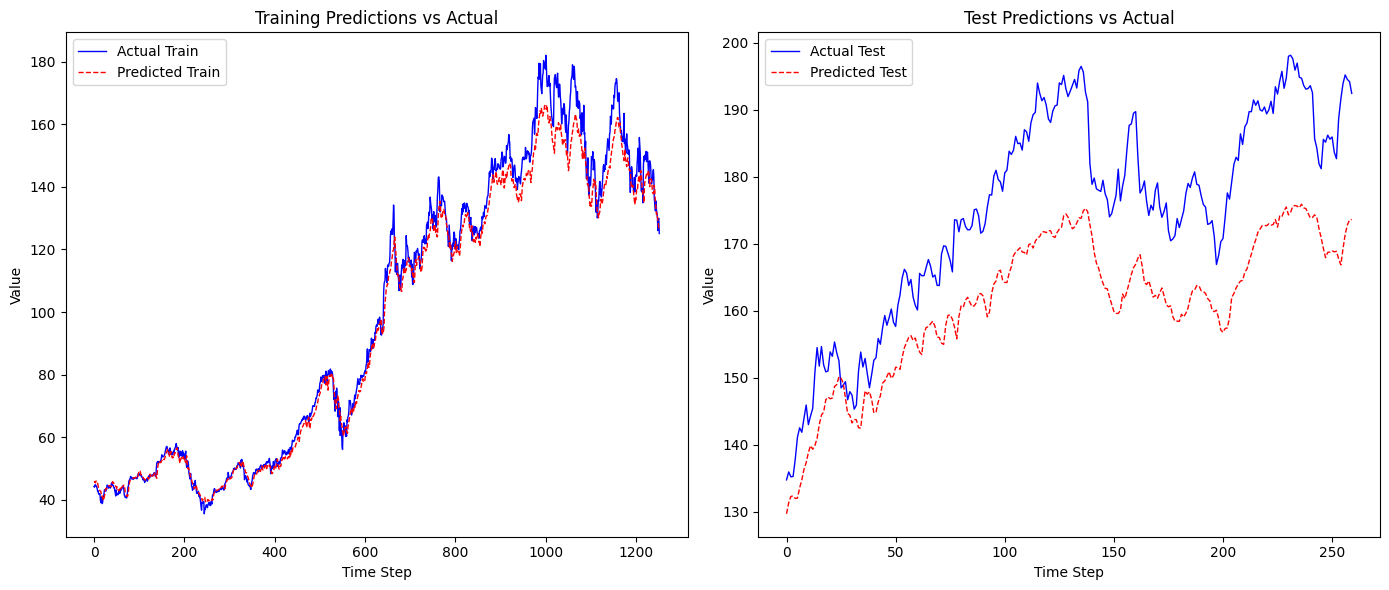

In [22]:
import matplotlib.pyplot as plt

# Assuming y_train and y_test are your original data, not the scaled version.
# And assuming pred_list contains predictions for the best model after inverse transformation.

# Note: Adjust the indexing if needed, depending on how your data and predictions are aligned.

# Plotting
plt.figure(figsize=(14, 6))

# Training predictions and actual
plt.subplot(1, 2, 1)
plt.plot(y_train[n_steps:], label='Actual Train', color='blue', linestyle='-', linewidth=1)
plt.plot(pred_list['train_pred'], label='Predicted Train', color='red', linestyle='--', linewidth=1)
plt.title('Training Predictions vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()

# Test predictions and actual
plt.subplot(1, 2, 2)
plt.plot(y_test[n_steps:], label='Actual Test', color='blue', linestyle='-', linewidth=1)
plt.plot(pred_list['test_pred'], label='Predicted Test', color='red', linestyle='--', linewidth=1)
plt.title('Test Predictions vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()

plt.tight_layout()
plt.show()


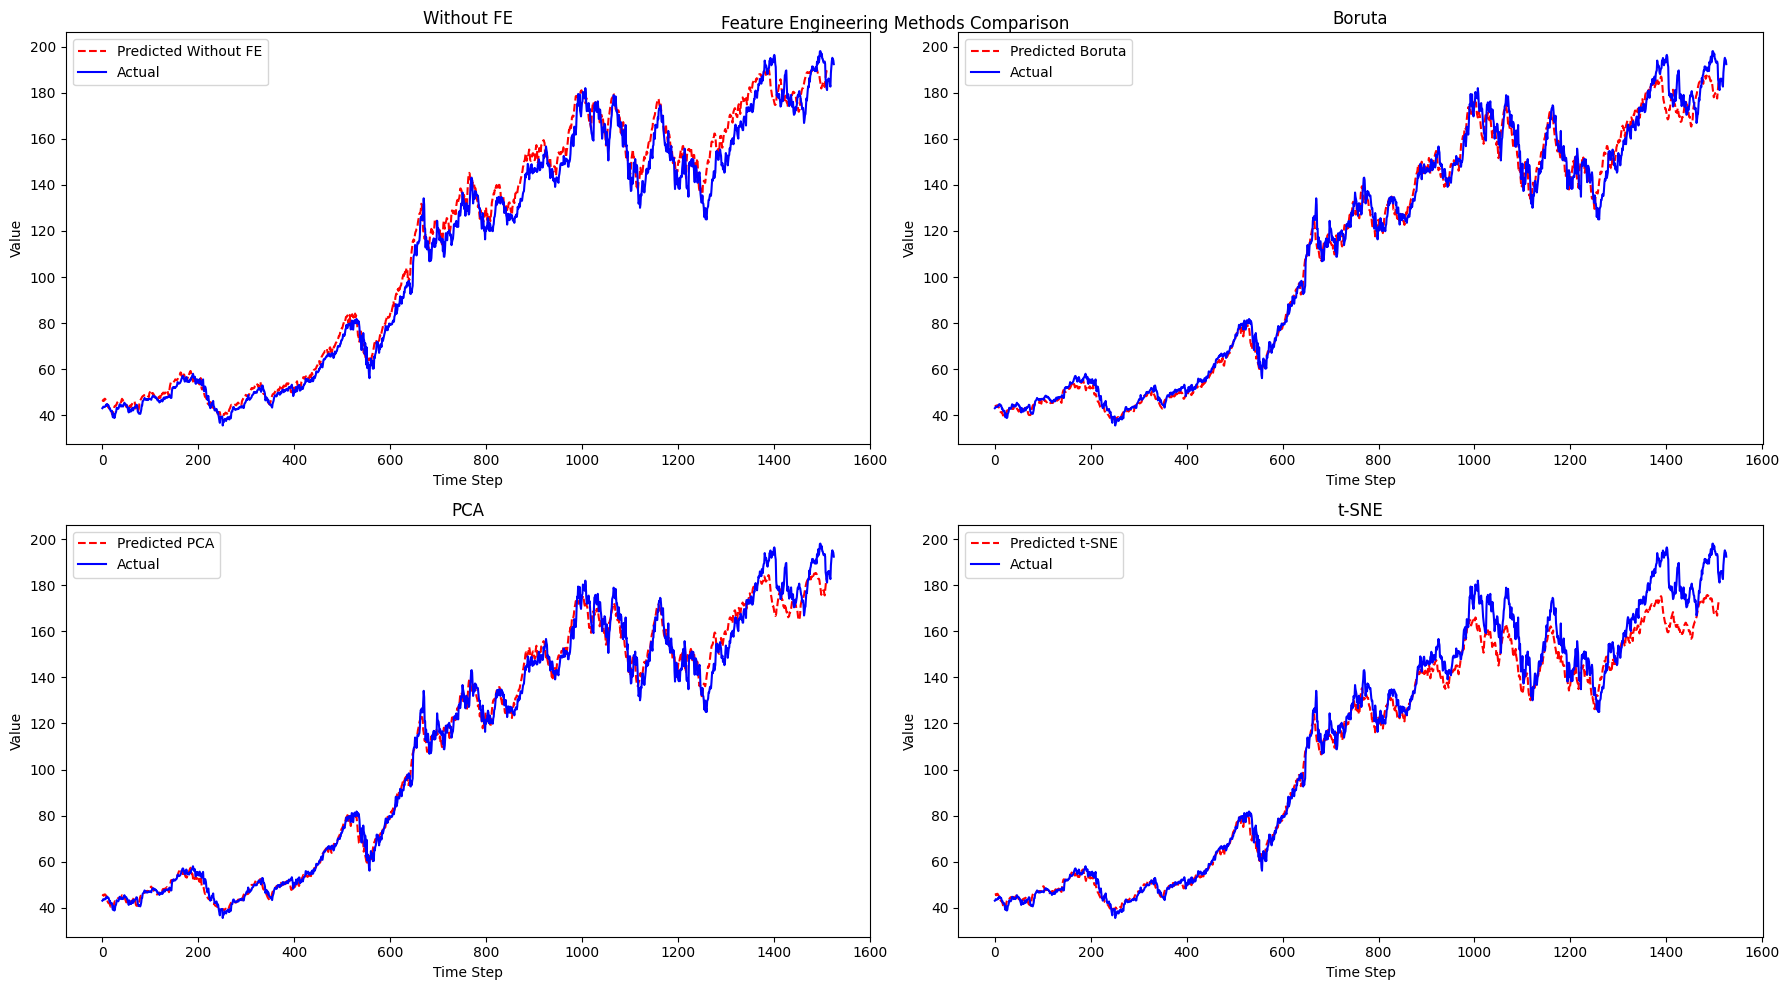

In [23]:
import matplotlib.pyplot as plt

# Assuming y_actual is prepared outside this snippet as suggested.
# Example: y_actual = np.concatenate((y_train, y_test), axis=0)

plt.figure(figsize=(18, 10))

for i, (method_name, pred_list) in enumerate(predictions_total.items(), start=1):
    # Concatenate train and test predictions for continuity
    predictions = np.concatenate((pred_list['train_pred'], pred_list['test_pred']), axis=0)

    # Plot
    plt.subplot(2, 2, i)
    plt.plot(predictions, label=f'Predicted {method_name}', linestyle='--', marker='', color='red')
    plt.plot(y_actual, label='Actual', linestyle='-', marker='', color='blue')
    plt.title(f'{method_name}')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()

plt.tight_layout()
plt.suptitle('Feature Engineering Methods Comparison')
plt.show()


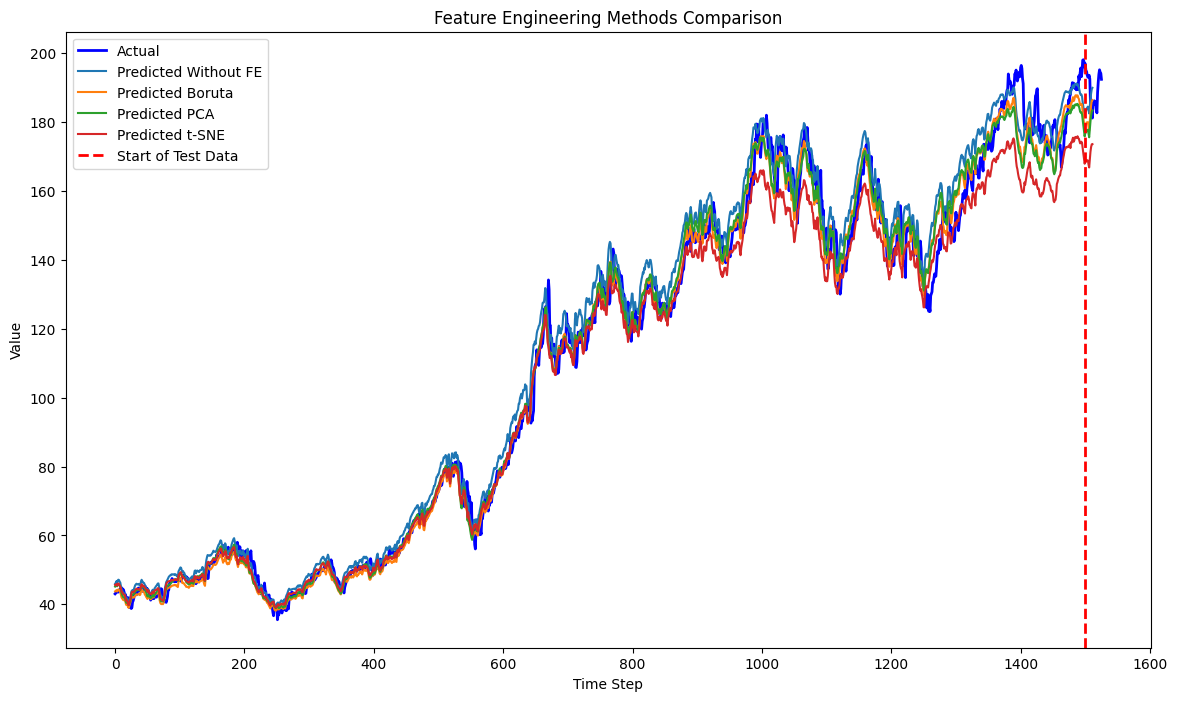

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'predictions_total' is a dictionary containing prediction arrays for each feature engineering method
# And 'y_actual' contains the concatenated actual values (train + test)

# Prepare the plot
plt.figure(figsize=(14, 8))

# Plot actual values
plt.plot(y_actual, label='Actual', color='blue', linewidth=2)

# Plot predictions for each feature engineering method
for method, predictions in predictions_total.items():
    # Concatenate train and test predictions for continuity
    pred_combined = np.concatenate((predictions['train_pred'], predictions['test_pred']), axis=0)
    plt.plot(pred_combined, label=f'Predicted {method}')

# Optionally, if you know the index where test data starts, you can add a vertical line to indicate it
# For example, if test data starts at index 1500, you could do:
plt.axvline(x=1500, color='red', linestyle='--', linewidth=2, label='Start of Test Data')

# Final plot adjustments
plt.title('Feature Engineering Methods Comparison')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()


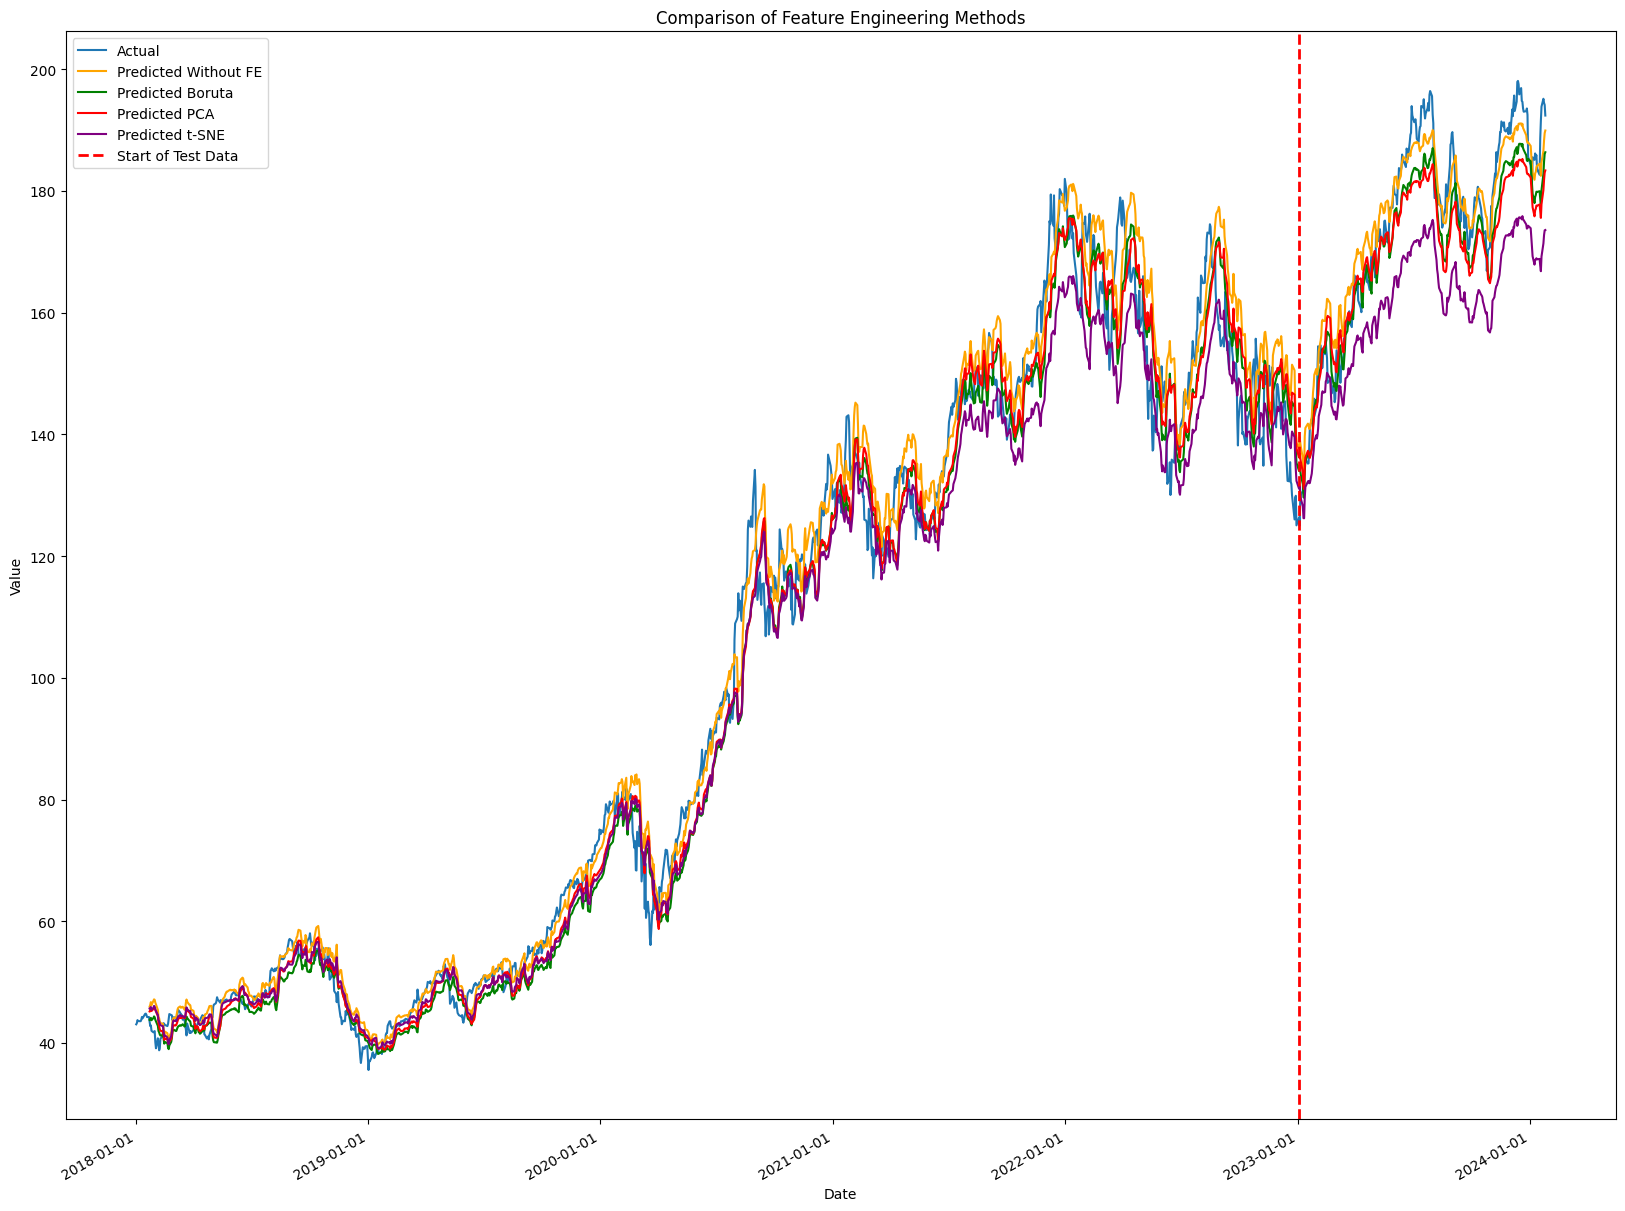

In [40]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

# Convert 'dates' to a Pandas DatetimeIndex for plotting if it's not already
dates = np.concatenate((Train_date, Test_date), axis=0)
y_actual = np.concatenate((y_train, y_test), axis=0)

# Ensure dates is a datetime object for plotting
dates = pd.to_datetime(dates)
plt.rcParams["figure.figsize"] = (20, 16)
#plt.figure(figsize=(15, 8))  # Adjust the figure size as needed

# Plot the actual values
plt.plot(dates, y_actual, label='Actual')

# Plot predictions from each feature engineering method
colors = ['orange', 'green', 'red', 'purple']  # Different colors for each method
for method, preds in predictions_total.items():
    preds_combined = np.concatenate((preds['train_pred'].flatten(), preds['test_pred'].flatten()))
    if preds_combined.shape[0] < dates.shape[0]:
        # Pad predictions with NaNs for alignment
        pad_length = dates.shape[0] - preds_combined.shape[0]
        preds_combined = np.concatenate((np.full(pad_length, np.nan), preds_combined))

    plt.plot(dates, preds_combined, label=f'Predicted {method}',color=colors.pop(0))

# Mark the start of test data with a vertical line
test_start_date = '2023-01-03'  # Replace with the actual start date of your test set
plt.axvline(x=pd.to_datetime(test_start_date), color='red', linestyle='--', linewidth=2, label='Start of Test Data')

# Finalize the plot
plt.title('Comparison of Feature Engineering Methods')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format the x-axis with dates
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Set major ticks to yearly intervals
plt.gcf().autofmt_xdate()  # Auto-format date labels

plt.show()


# **Test 2**


In [42]:
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Pre-Loading
y_train = pd.read_csv("FE results/y_train.csv")
y_train = y_train.drop(columns=['Unnamed: 0'])
y_test = pd.read_csv("FE results/y_test.csv")
y_test = y_test.drop(columns=['Unnamed: 0'])


# Load Data
X_train = pd.read_csv("FE results/Train_original.csv")
Train_date = X_train['Date']
X_train = X_train.drop(columns=['Unnamed: 0', 'Date'])
X_test = pd.read_csv("FE results/Test_original.csv")
Test_date = X_test['Date']
X_test = X_test.drop(columns=['Unnamed: 0', 'Date'])

# Initialize scaler
scaler_x = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Normalize features
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

# Assuming y_train and y_test are single columns and not DataFrames at this point
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

def create_sequences(input_data, target_data, n_steps):
    X, y = [], []
    for i in range(len(input_data) - n_steps):
        X.append(input_data[i:i+n_steps])
        y.append(target_data[i+n_steps, 0])  # Assuming target_data is the column vector
    return np.array(X), np.array(y)

n_steps = 7  # Define the number of steps in your sequence
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, n_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, n_steps)



In [43]:

def create_lstm_model(input_shape, optimizer='adam', lstm_units=50, dropout_rate=0.2, l2_regularization=0.01):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=lstm_units, return_sequences=True), input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, kernel_regularizer=l2(l2_regularization)))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

def run_optuna_optimization(X_train, y_train, X_test, y_test, n_steps, n_trials=5):
    def lstm_objective(trial):
        # (The same initialization and preprocessing code as before)

        # Suggest batch size as a hyperparameter
        batch_size = trial.suggest_categorical('batch_size', [32, 64])

        # Hyperparameters
        lstm_units = trial.suggest_categorical('lstm_units', [50, 100])
        dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
        learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)

        # Model definition
        model = create_lstm_model(input_shape=(n_steps, X_train_seq.shape[2]),
                                  lstm_units=lstm_units,
                                  dropout_rate=dropout_rate,
                                  optimizer=Adam(learning_rate=learning_rate))

        # Train the model with the suggested batch size
        model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=batch_size, validation_split=0.2, verbose=0)

        # Evaluate
        train_pred_scaled = model.predict(X_train_seq)
        test_pred_scaled = model.predict(X_test_seq)
        train_pred = scaler_y.inverse_transform(train_pred_scaled)
        test_pred = scaler_y.inverse_transform(test_pred_scaled)

        # Metrics
        train_mae = mean_absolute_error(y_train[n_steps:], train_pred)
        train_rmse = np.sqrt(mean_squared_error(y_train[n_steps:], train_pred))
        test_mae = mean_absolute_error(y_test[n_steps:], test_pred)
        test_rmse = np.sqrt(mean_squared_error(y_test[n_steps:], test_pred))

        trial.set_user_attr('train_mae', train_mae)
        trial.set_user_attr('train_rmse', train_rmse)
        trial.set_user_attr('test_mae', test_mae)
        trial.set_user_attr('test_rmse', test_rmse)

        return test_rmse

    study = optuna.create_study(direction='minimize')
    study.optimize(lstm_objective, n_trials=n_trials)

    best_trial = study.best_trial

    # Re-train the best model to get predictions for visualization, using best parameters including batch size
    best_params = best_trial.params
    model = create_lstm_model(
        input_shape=(n_steps, X_train_seq.shape[2]),
        lstm_units=best_params['lstm_units'],
        dropout_rate=best_params['dropout_rate'],
        optimizer=Adam(learning_rate=best_params['learning_rate'])
    )
    # Use the best batch size from Optuna's optimization
    model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=best_params['batch_size'], validation_split=0.2, verbose=0)

    # Predict with the best model
    train_pred = scaler_y.inverse_transform(model.predict(X_train_seq))
    test_pred = scaler_y.inverse_transform(model.predict(X_test_seq))
    pred_list = {'train_pred': train_pred, 'test_pred': test_pred}

    results = {
        'Feature Engineering Method': 'Method Name',  # This will be replaced by the actual method name later
        'Best Trial Train MAE': best_trial.user_attrs['train_mae'],
        'Best Trial Train RMSE': best_trial.user_attrs['train_rmse'],
        'Best Trial Test MAE': best_trial.user_attrs['test_mae'],
        'Best Trial Test RMSE': best_trial.user_attrs['test_rmse'],
        'Best Params': best_trial.params
    }

    return results, pred_list


In [44]:

results_total = []
predictions_total = {}
# Placeholder for method names and corresponding data files
fe_methods_data = {
    'Without FE': ('./FE results/Train_original.csv', './FE results/Test_original.csv'),
    'Boruta': ('./FE results/Train_boruta.csv', './FE results/Test_boruta.csv'),
    'PCA': ('./FE results/Train_pca.csv', './FE results/Test_pca.csv'),
    't-SNE': ('./FE results/Train_tsne.csv', './FE results/Test_tsne.csv'),
}


for method_name, (train_file, test_file) in fe_methods_data.items():
    print(f'\n####### {method_name} #######')
    X_train = pd.read_csv(train_file).drop(columns=['Unnamed: 0', 'Date'])
    y_train = pd.read_csv("FE results/y_train.csv").drop(columns=['Unnamed: 0']).values.ravel()
    X_test = pd.read_csv(test_file).drop(columns=['Unnamed: 0', 'Date'])
    y_test = pd.read_csv("FE results/y_test.csv").drop(columns=['Unnamed: 0']).values.ravel()

    results, pred_list = run_optuna_optimization(X_train, y_train, X_test, y_test, n_steps, n_trials=10)
    results['Feature Engineering Method'] = method_name  # Set the method name in the results

    results_total.append(results)
    predictions_total[method_name] = pred_list  # Store predictions by method

# Convert results_total to DataFrame for easier analysis if needed
results_df = pd.DataFrame(results_total)
print(results_df)

# Now, predictions_total contains the pred_list for each feature engineering method


[I 2024-03-11 00:43:25,843] A new study created in memory with name: no-name-b49d3202-a6c3-469c-989b-c34818dc41a8



####### Without FE #######


<ipython-input-43-79db9aa5da7c>:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-43-79db9aa5da7c>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 5ms/step


[I 2024-03-11 00:44:16,272] Trial 0 finished with value: 10.620175001062876 and parameters: {'batch_size': 64, 'lstm_units': 50, 'dropout_rate': 0.18353696292824662, 'learning_rate': 0.005865799523973691}. Best is trial 0 with value: 10.620175001062876.
<ipython-input-43-79db9aa5da7c>:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-43-79db9aa5da7c>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 7ms/step


[I 2024-03-11 00:46:46,148] Trial 1 finished with value: 9.663851849812934 and parameters: {'batch_size': 32, 'lstm_units': 100, 'dropout_rate': 0.17346824430140545, 'learning_rate': 0.004769546268891715}. Best is trial 1 with value: 9.663851849812934.
<ipython-input-43-79db9aa5da7c>:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-43-79db9aa5da7c>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 8ms/step


[I 2024-03-11 00:49:16,888] Trial 2 finished with value: 8.393219341759988 and parameters: {'batch_size': 32, 'lstm_units': 100, 'dropout_rate': 0.15415895030704627, 'learning_rate': 0.0026178831670515923}. Best is trial 2 with value: 8.393219341759988.
<ipython-input-43-79db9aa5da7c>:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-43-79db9aa5da7c>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 9ms/step


[I 2024-03-11 00:50:52,338] Trial 3 finished with value: 9.523627886410681 and parameters: {'batch_size': 64, 'lstm_units': 100, 'dropout_rate': 0.18596828269683288, 'learning_rate': 0.002846714852728561}. Best is trial 2 with value: 8.393219341759988.
<ipython-input-43-79db9aa5da7c>:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-43-79db9aa5da7c>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 9ms/step


[I 2024-03-11 00:52:17,807] Trial 4 finished with value: 13.02755831436955 and parameters: {'batch_size': 64, 'lstm_units': 100, 'dropout_rate': 0.1654282440277805, 'learning_rate': 0.0028609965767609244}. Best is trial 2 with value: 8.393219341759988.
<ipython-input-43-79db9aa5da7c>:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-43-79db9aa5da7c>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 6ms/step


[I 2024-03-11 00:52:59,481] Trial 5 finished with value: 11.803175105319454 and parameters: {'batch_size': 64, 'lstm_units': 50, 'dropout_rate': 0.18596542698639842, 'learning_rate': 0.001386001700752934}. Best is trial 2 with value: 8.393219341759988.
<ipython-input-43-79db9aa5da7c>:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-43-79db9aa5da7c>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 9ms/step


[I 2024-03-11 00:54:29,440] Trial 6 finished with value: 8.00750652826892 and parameters: {'batch_size': 64, 'lstm_units': 100, 'dropout_rate': 0.11366377374536957, 'learning_rate': 0.001973672761860057}. Best is trial 6 with value: 8.00750652826892.
<ipython-input-43-79db9aa5da7c>:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-43-79db9aa5da7c>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 9ms/step


[I 2024-03-11 00:56:00,847] Trial 7 finished with value: 6.9757895749205705 and parameters: {'batch_size': 32, 'lstm_units': 100, 'dropout_rate': 0.170569741108823, 'learning_rate': 0.001607697781108573}. Best is trial 7 with value: 6.9757895749205705.
<ipython-input-43-79db9aa5da7c>:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-43-79db9aa5da7c>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 6ms/step


[I 2024-03-11 00:56:58,845] Trial 8 finished with value: 6.079896612355884 and parameters: {'batch_size': 32, 'lstm_units': 50, 'dropout_rate': 0.15991713921225065, 'learning_rate': 0.0022055796087326607}. Best is trial 8 with value: 6.079896612355884.
<ipython-input-43-79db9aa5da7c>:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-43-79db9aa5da7c>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 9ms/step


[I 2024-03-11 00:58:28,590] Trial 9 finished with value: 7.061812153043389 and parameters: {'batch_size': 64, 'lstm_units': 100, 'dropout_rate': 0.11469745170974995, 'learning_rate': 0.0010260285562167766}. Best is trial 8 with value: 6.079896612355884.


9/9 [==============================] - 0s 5ms/step


[I 2024-03-11 00:59:59,525] A new study created in memory with name: no-name-8a89e182-e9b8-4d83-88a9-0023af1f3e4d



####### Boruta #######


<ipython-input-43-79db9aa5da7c>:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-43-79db9aa5da7c>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 6ms/step


[I 2024-03-11 01:01:33,537] Trial 0 finished with value: 8.629965285353665 and parameters: {'batch_size': 32, 'lstm_units': 50, 'dropout_rate': 0.1529691987993398, 'learning_rate': 0.0011677336762137465}. Best is trial 0 with value: 8.629965285353665.
<ipython-input-43-79db9aa5da7c>:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-43-79db9aa5da7c>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 6ms/step


[I 2024-03-11 01:02:22,683] Trial 1 finished with value: 7.3641200778042295 and parameters: {'batch_size': 64, 'lstm_units': 50, 'dropout_rate': 0.19139006725105961, 'learning_rate': 0.00246360237661889}. Best is trial 1 with value: 7.3641200778042295.
<ipython-input-43-79db9aa5da7c>:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-43-79db9aa5da7c>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 4ms/step


[I 2024-03-11 01:03:52,788] Trial 2 finished with value: 10.20826697691087 and parameters: {'batch_size': 32, 'lstm_units': 50, 'dropout_rate': 0.1723348087873366, 'learning_rate': 0.0071384604815361375}. Best is trial 1 with value: 7.3641200778042295.
<ipython-input-43-79db9aa5da7c>:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-43-79db9aa5da7c>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 4ms/step


[I 2024-03-11 01:04:41,001] Trial 3 finished with value: 7.931568307408289 and parameters: {'batch_size': 64, 'lstm_units': 50, 'dropout_rate': 0.1191191752377234, 'learning_rate': 0.003434941299049755}. Best is trial 1 with value: 7.3641200778042295.
<ipython-input-43-79db9aa5da7c>:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-43-79db9aa5da7c>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 5ms/step


[I 2024-03-11 01:06:10,130] Trial 4 finished with value: 8.26189521765295 and parameters: {'batch_size': 32, 'lstm_units': 50, 'dropout_rate': 0.178123458169722, 'learning_rate': 0.009197422260792594}. Best is trial 1 with value: 7.3641200778042295.
<ipython-input-43-79db9aa5da7c>:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-43-79db9aa5da7c>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 4ms/step


[I 2024-03-11 01:07:06,435] Trial 5 finished with value: 6.921562453059786 and parameters: {'batch_size': 32, 'lstm_units': 50, 'dropout_rate': 0.1231898781501558, 'learning_rate': 0.005849555081093048}. Best is trial 5 with value: 6.921562453059786.
<ipython-input-43-79db9aa5da7c>:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-43-79db9aa5da7c>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 5ms/step


[I 2024-03-11 01:08:00,420] Trial 6 finished with value: 5.743428516530902 and parameters: {'batch_size': 32, 'lstm_units': 50, 'dropout_rate': 0.1482880573347621, 'learning_rate': 0.0037715422928552497}. Best is trial 6 with value: 5.743428516530902.
<ipython-input-43-79db9aa5da7c>:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-43-79db9aa5da7c>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 4ms/step


[I 2024-03-11 01:09:30,784] Trial 7 finished with value: 10.73969906266261 and parameters: {'batch_size': 32, 'lstm_units': 50, 'dropout_rate': 0.16015322721810876, 'learning_rate': 0.004893832331546747}. Best is trial 6 with value: 5.743428516530902.
<ipython-input-43-79db9aa5da7c>:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-43-79db9aa5da7c>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 4ms/step


[I 2024-03-11 01:10:59,927] Trial 8 finished with value: 5.179253188952053 and parameters: {'batch_size': 32, 'lstm_units': 50, 'dropout_rate': 0.17006974901604777, 'learning_rate': 0.005973521587824367}. Best is trial 8 with value: 5.179253188952053.
<ipython-input-43-79db9aa5da7c>:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-43-79db9aa5da7c>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 10ms/step


[I 2024-03-11 01:12:34,554] Trial 9 finished with value: 6.82415174566393 and parameters: {'batch_size': 32, 'lstm_units': 100, 'dropout_rate': 0.1491503166238321, 'learning_rate': 0.0029215687683002236}. Best is trial 8 with value: 5.179253188952053.


9/9 [==============================] - 0s 5ms/step


[I 2024-03-11 01:14:04,090] A new study created in memory with name: no-name-337ad83c-8587-4cb2-9ae4-2acb73575a59



####### PCA #######


<ipython-input-43-79db9aa5da7c>:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-43-79db9aa5da7c>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 13ms/step


[I 2024-03-11 01:15:34,305] Trial 0 finished with value: 13.291234431607315 and parameters: {'batch_size': 64, 'lstm_units': 100, 'dropout_rate': 0.19857532004767, 'learning_rate': 0.0020287228145794193}. Best is trial 0 with value: 13.291234431607315.
<ipython-input-43-79db9aa5da7c>:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-43-79db9aa5da7c>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 8ms/step


[I 2024-03-11 01:16:54,509] Trial 1 finished with value: 16.867627591321 and parameters: {'batch_size': 64, 'lstm_units': 100, 'dropout_rate': 0.16385883968383017, 'learning_rate': 0.008209771834644447}. Best is trial 0 with value: 13.291234431607315.
<ipython-input-43-79db9aa5da7c>:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-43-79db9aa5da7c>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 5ms/step


[I 2024-03-11 01:17:35,030] Trial 2 finished with value: 9.212079033875042 and parameters: {'batch_size': 64, 'lstm_units': 50, 'dropout_rate': 0.13436391825796073, 'learning_rate': 0.008883564627219271}. Best is trial 2 with value: 9.212079033875042.
<ipython-input-43-79db9aa5da7c>:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-43-79db9aa5da7c>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 8ms/step


[I 2024-03-11 01:18:52,811] Trial 3 finished with value: 5.711442761761117 and parameters: {'batch_size': 64, 'lstm_units': 100, 'dropout_rate': 0.104426659905343, 'learning_rate': 0.0011238377650011537}. Best is trial 3 with value: 5.711442761761117.
<ipython-input-43-79db9aa5da7c>:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-43-79db9aa5da7c>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 7ms/step


[I 2024-03-11 01:21:22,971] Trial 4 finished with value: 5.693089687719685 and parameters: {'batch_size': 32, 'lstm_units': 100, 'dropout_rate': 0.14212606443303513, 'learning_rate': 0.001972437436818697}. Best is trial 4 with value: 5.693089687719685.
<ipython-input-43-79db9aa5da7c>:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-43-79db9aa5da7c>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 5ms/step


[I 2024-03-11 01:22:52,037] Trial 5 finished with value: 7.527519021946476 and parameters: {'batch_size': 32, 'lstm_units': 50, 'dropout_rate': 0.15822850550563902, 'learning_rate': 0.0016728656067634697}. Best is trial 4 with value: 5.693089687719685.
<ipython-input-43-79db9aa5da7c>:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-43-79db9aa5da7c>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 8ms/step


[I 2024-03-11 01:24:22,377] Trial 6 finished with value: 5.746028566357465 and parameters: {'batch_size': 32, 'lstm_units': 50, 'dropout_rate': 0.19627675249767573, 'learning_rate': 0.0071814461370223424}. Best is trial 4 with value: 5.693089687719685.
<ipython-input-43-79db9aa5da7c>:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-43-79db9aa5da7c>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 8ms/step


[I 2024-03-11 01:25:52,004] Trial 7 finished with value: 5.918509330858582 and parameters: {'batch_size': 32, 'lstm_units': 100, 'dropout_rate': 0.19139709881013742, 'learning_rate': 0.008695588082928285}. Best is trial 4 with value: 5.693089687719685.
<ipython-input-43-79db9aa5da7c>:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-43-79db9aa5da7c>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 5ms/step


[I 2024-03-11 01:26:40,167] Trial 8 finished with value: 8.382451650034586 and parameters: {'batch_size': 64, 'lstm_units': 50, 'dropout_rate': 0.15217215777678722, 'learning_rate': 0.0024244034644390145}. Best is trial 4 with value: 5.693089687719685.
<ipython-input-43-79db9aa5da7c>:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-43-79db9aa5da7c>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 17ms/step


[I 2024-03-11 01:28:15,678] Trial 9 finished with value: 11.585772886681807 and parameters: {'batch_size': 64, 'lstm_units': 100, 'dropout_rate': 0.1151049797377584, 'learning_rate': 0.0019838866009430148}. Best is trial 4 with value: 5.693089687719685.


9/9 [==============================] - 0s 9ms/step


[I 2024-03-11 01:29:57,628] A new study created in memory with name: no-name-85d04732-86b7-4d1a-898c-a5c371cd6d8f



####### t-SNE #######


<ipython-input-43-79db9aa5da7c>:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-43-79db9aa5da7c>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 13ms/step


[I 2024-03-11 01:31:33,828] Trial 0 finished with value: 5.012586790329928 and parameters: {'batch_size': 32, 'lstm_units': 100, 'dropout_rate': 0.11911698908916099, 'learning_rate': 0.009860751913664735}. Best is trial 0 with value: 5.012586790329928.
<ipython-input-43-79db9aa5da7c>:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-43-79db9aa5da7c>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 8ms/step


[I 2024-03-11 01:33:03,787] Trial 1 finished with value: 12.105709591127194 and parameters: {'batch_size': 64, 'lstm_units': 100, 'dropout_rate': 0.16922418461660615, 'learning_rate': 0.0073363649429455625}. Best is trial 0 with value: 5.012586790329928.
<ipython-input-43-79db9aa5da7c>:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-43-79db9aa5da7c>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 5ms/step


[I 2024-03-11 01:34:32,739] Trial 2 finished with value: 16.93073857906642 and parameters: {'batch_size': 32, 'lstm_units': 50, 'dropout_rate': 0.12199753130116064, 'learning_rate': 0.005667614398519415}. Best is trial 0 with value: 5.012586790329928.
<ipython-input-43-79db9aa5da7c>:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-43-79db9aa5da7c>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 8ms/step


[I 2024-03-11 01:35:50,233] Trial 3 finished with value: 5.533992582315172 and parameters: {'batch_size': 64, 'lstm_units': 100, 'dropout_rate': 0.1912764376220856, 'learning_rate': 0.003125112997312194}. Best is trial 0 with value: 5.012586790329928.
<ipython-input-43-79db9aa5da7c>:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-43-79db9aa5da7c>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 11ms/step


[I 2024-03-11 01:37:20,728] Trial 4 finished with value: 8.499100856835472 and parameters: {'batch_size': 32, 'lstm_units': 100, 'dropout_rate': 0.1793011891415558, 'learning_rate': 0.0015284569931560787}. Best is trial 0 with value: 5.012586790329928.
<ipython-input-43-79db9aa5da7c>:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-43-79db9aa5da7c>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 5ms/step


[I 2024-03-11 01:38:00,993] Trial 5 finished with value: 8.512625144693496 and parameters: {'batch_size': 64, 'lstm_units': 50, 'dropout_rate': 0.19486042253798266, 'learning_rate': 0.0022562581659977114}. Best is trial 0 with value: 5.012586790329928.
<ipython-input-43-79db9aa5da7c>:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-43-79db9aa5da7c>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 8ms/step


[I 2024-03-11 01:39:30,319] Trial 6 finished with value: 8.049276626722751 and parameters: {'batch_size': 32, 'lstm_units': 100, 'dropout_rate': 0.11110253691536444, 'learning_rate': 0.008136579417284401}. Best is trial 0 with value: 5.012586790329928.
<ipython-input-43-79db9aa5da7c>:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-43-79db9aa5da7c>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 8ms/step


[I 2024-03-11 01:40:46,859] Trial 7 finished with value: 10.987137124984212 and parameters: {'batch_size': 64, 'lstm_units': 100, 'dropout_rate': 0.16402847915616703, 'learning_rate': 0.0010562541825796066}. Best is trial 0 with value: 5.012586790329928.
<ipython-input-43-79db9aa5da7c>:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-43-79db9aa5da7c>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 7ms/step


[I 2024-03-11 01:42:01,996] Trial 8 finished with value: 11.167372185578806 and parameters: {'batch_size': 64, 'lstm_units': 100, 'dropout_rate': 0.12656947114773678, 'learning_rate': 0.001956928783758727}. Best is trial 0 with value: 5.012586790329928.
<ipython-input-43-79db9aa5da7c>:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-43-79db9aa5da7c>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 4ms/step


[I 2024-03-11 01:42:41,938] Trial 9 finished with value: 6.449750238934199 and parameters: {'batch_size': 64, 'lstm_units': 50, 'dropout_rate': 0.16708831322531265, 'learning_rate': 0.004742210085479662}. Best is trial 0 with value: 5.012586790329928.


9/9 [==============================] - 0s 11ms/step
  Feature Engineering Method  Best Trial Train MAE  Best Trial Train RMSE  \
0                 Without FE              2.572209               3.750785   
1                     Boruta              2.606834               3.927894   
2                        PCA              2.188165               3.139947   
3                      t-SNE              3.867462               5.071804   

   Best Trial Test MAE  Best Trial Test RMSE  \
0             4.938600              6.079897   
1             4.235185              5.179253   
2             4.666966              5.693090   
3             4.134395              5.012587   

                                         Best Params  
0  {'batch_size': 32, 'lstm_units': 50, 'dropout_...  
1  {'batch_size': 32, 'lstm_units': 50, 'dropout_...  
2  {'batch_size': 32, 'lstm_units': 100, 'dropout...  
3  {'batch_size': 32, 'lstm_units': 100, 'dropout...  


In [46]:
results_df

,Feature Engineering Method,Best Trial Train MAE,Best Trial Train RMSE,Best Trial Test MAE,Best Trial Test RMSE,Best Params
0,Without FE,2.572209,3.750785,4.938600,6.079897,"{'batch_size': 32, 'lstm_units': 50, 'dropout_..."
1,Boruta,2.606834,3.927894,4.235185,5.179253,"{'batch_size': 32, 'lstm_units': 50, 'dropout_..."
2,PCA,2.188165,3.139947,4.666966,5.693090,"{'batch_size': 32, 'lstm_units': 100, 'dropout..."
3,t-SNE,3.867462,5.071804,4.134395,5.012587,"{'batch_size': 32, 'lstm_units': 100, 'dropout..."


In [47]:
results_total

[{'Feature Engineering Method': 'Without FE',
  'Best Trial Train MAE': 2.572208678799663,
  'Best Trial Train RMSE': 3.7507845066018133,
  'Best Trial Test MAE': 4.938600270072115,
  'Best Trial Test RMSE': 6.079896612355884,
  'Best Params': {'batch_size': 32,
   'lstm_units': 50,
   'dropout_rate': 0.15991713921225065,
   'learning_rate': 0.0022055796087326607}},
 {'Feature Engineering Method': 'Boruta',
  'Best Trial Train MAE': 2.60683373845168,
  'Best Trial Train RMSE': 3.92789383742241,
  'Best Trial Test MAE': 4.235184823275992,
  'Best Trial Test RMSE': 5.179253188952053,
  'Best Params': {'batch_size': 32,
   'lstm_units': 50,
   'dropout_rate': 0.17006974901604777,
   'learning_rate': 0.005973521587824367}},
 {'Feature Engineering Method': 'PCA',
  'Best Trial Train MAE': 2.18816469925073,
  'Best Trial Train RMSE': 3.139947078490959,
  'Best Trial Test MAE': 4.66696646514423,
  'Best Trial Test RMSE': 5.693089687719685,
  'Best Params': {'batch_size': 32,
   'lstm_units': 

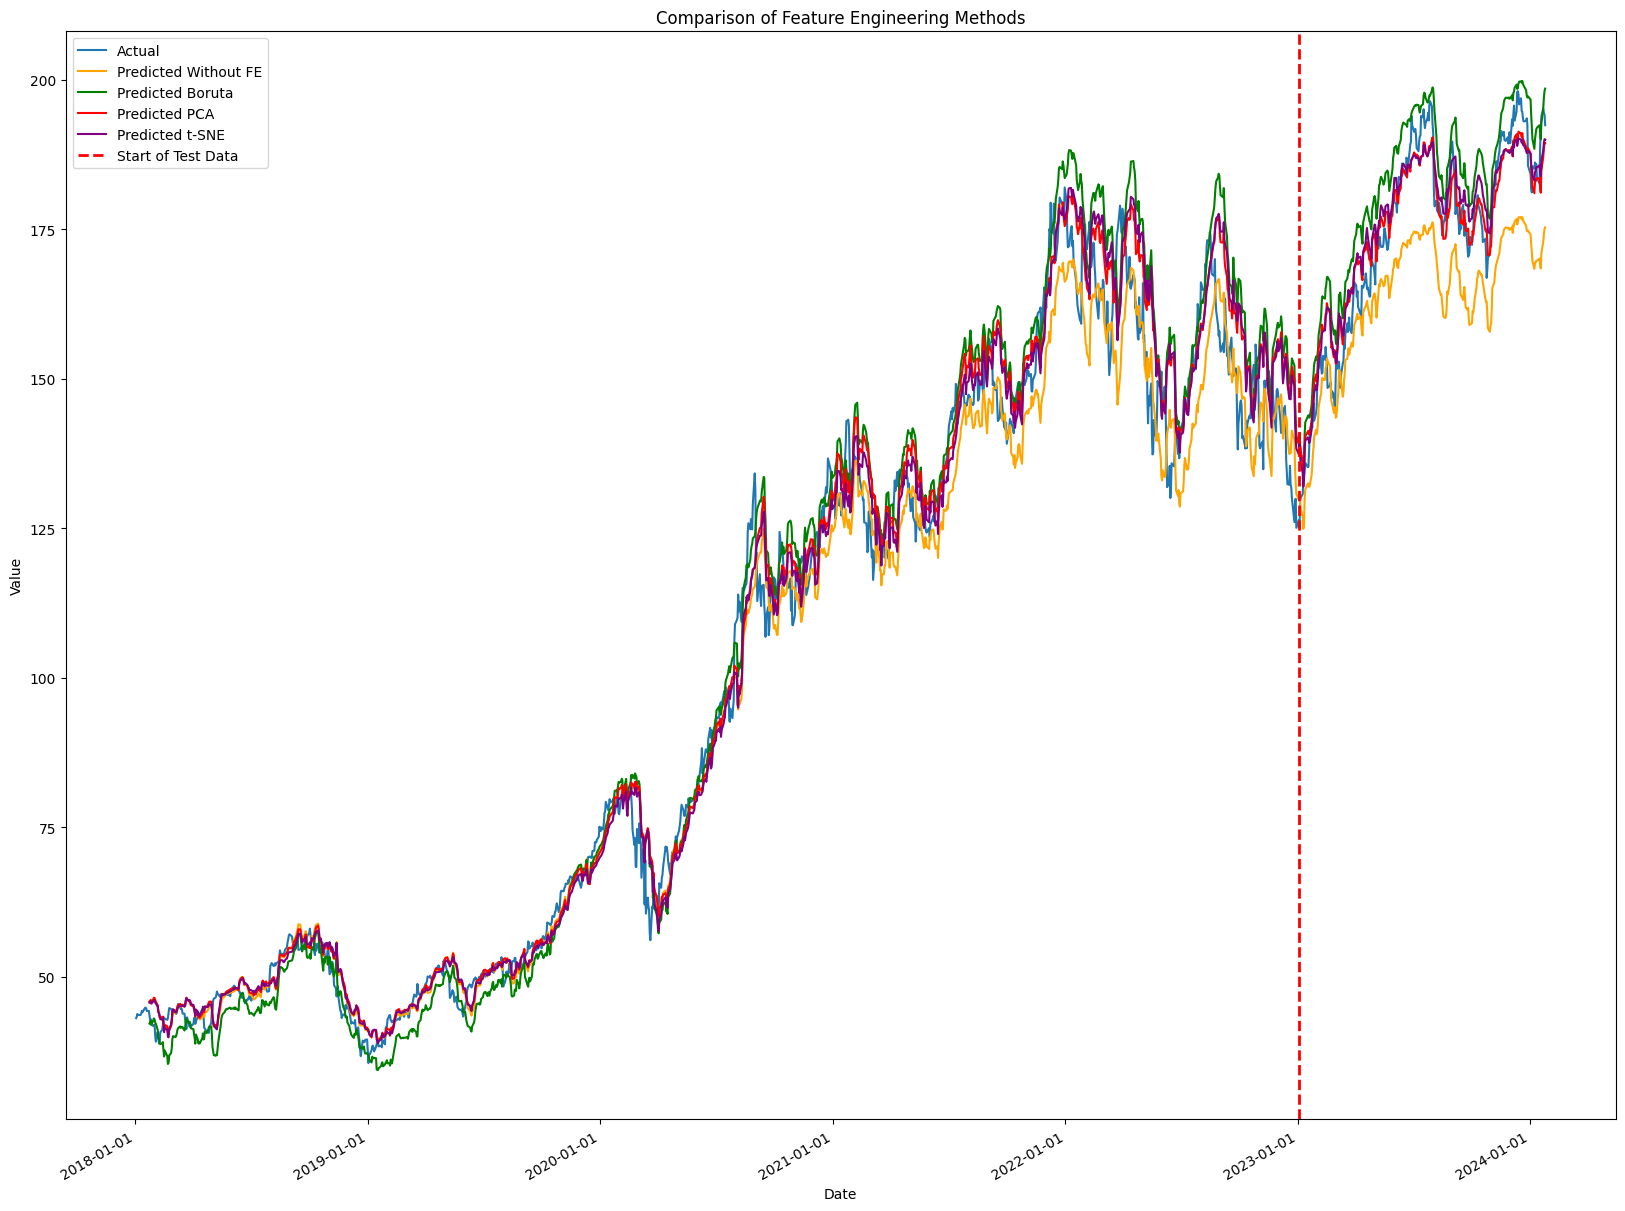

In [45]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

# Convert 'dates' to a Pandas DatetimeIndex for plotting if it's not already
dates = np.concatenate((Train_date, Test_date), axis=0)
y_actual = np.concatenate((y_train, y_test), axis=0)

# Ensure dates is a datetime object for plotting
dates = pd.to_datetime(dates)
plt.rcParams["figure.figsize"] = (20, 16)
#plt.figure(figsize=(15, 8))  # Adjust the figure size as needed

# Plot the actual values
plt.plot(dates, y_actual, label='Actual')

# Plot predictions from each feature engineering method
colors = ['orange', 'green', 'red', 'purple']  # Different colors for each method
for method, preds in predictions_total.items():
    preds_combined = np.concatenate((preds['train_pred'].flatten(), preds['test_pred'].flatten()))
    if preds_combined.shape[0] < dates.shape[0]:
        # Pad predictions with NaNs for alignment
        pad_length = dates.shape[0] - preds_combined.shape[0]
        preds_combined = np.concatenate((np.full(pad_length, np.nan), preds_combined))

    plt.plot(dates, preds_combined, label=f'Predicted {method}',color=colors.pop(0))

# Mark the start of test data with a vertical line
test_start_date = '2023-01-03'  # Replace with the actual start date of your test set
plt.axvline(x=pd.to_datetime(test_start_date), color='red', linestyle='--', linewidth=2, label='Start of Test Data')

# Finalize the plot
plt.title('Comparison of Feature Engineering Methods')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format the x-axis with dates
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Set major ticks to yearly intervals
plt.gcf().autofmt_xdate()  # Auto-format date labels

plt.show()


In [36]:
results_total = []

# Models Training
Results, pred_list = Multiple_models(X_train, y_train, X_test, y_test, cv, verbose)

print(f'Results {Results}')
print(f'pred_list {pred_list}')
results_total.append(Results)

print('\n\n##################################################\nWithout Feature Engineering')
print(Results)
pred_total['Without Feature Engineering'] = pred_list

# Boruta
print('\n####### Boruta #######')
# Load Data
X_train = pd.read_csv('./FE results/Train_boruta.csv')
X_train = X_train.drop(columns=['Unnamed: 0', 'Date'])
X_test = pd.read_csv("FE results/Test_boruta.csv")
X_test = X_test.drop(columns=['Unnamed: 0', 'Date'])
# Models Training
Results, pred_list = Multiple_models(X_train, y_train, X_test, y_test, cv, verbose)
results_total.append(Results)

print('\n\n##################################################\nBoruta')
print(Results)
pred_total['Boruta'] = pred_list

# PCA
print('\n####### PCA #######')
# Load Data
X_train = pd.read_csv('./FE results/Train_pca.csv')
X_train = X_train.drop(columns=['Unnamed: 0', 'Date'])
X_test = pd.read_csv("FE results/Test_pca.csv")
X_test = X_test.drop(columns=['Unnamed: 0', 'Date'])
# Models Training
Results, pred_list = Multiple_models(X_train, y_train, X_test, y_test, cv, verbose)
results_total.append(Results)

print('\n\n##################################################\nPCA')
print(Results)
pred_total['PCA'] = pred_list

# t-SNE
print('\n####### t-SNE #######')
# Load Data
X_train = pd.read_csv('./FE results/Train_tsne.csv')
X_train = X_train.drop(columns=['Unnamed: 0', 'Date'])
X_test = pd.read_csv("FE results/Test_tsne.csv")
X_test = X_test.drop(columns=['Unnamed: 0', 'Date'])
# Models Training
Results, pred_list = Multiple_models(X_train, y_train, X_test, y_test, cv, verbose)
results_total.append(Results)

print('\n\n##################################################\nt-SNE')
print(Results)
pred_total['tSNE'] = pred_list

# Save Results
results_ = pd.concat(results_total, keys=['Without FE', 'Boruta', 'PCA', 't-SNE'])

results_.to_csv(f'results_1.csv')



# LSTM
Fitting 5 folds for each of 4 candidates, totalling 20 fits


KeyboardInterrupt: 

In [22]:
def lstm_objective(trial):
    # Define hyperparameters search space
    lstm_units = trial.suggest_categorical('lstm_units', [50, 100, 150])
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)

    # Model definition
    model = create_lstm_model(input_shape=(n_steps, X_train_seq.shape[2]),
                              lstm_units=lstm_units,
                              dropout_rate=dropout_rate,
                              optimizer=Adam(learning_rate=learning_rate))

    # Train the model
    history = model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=64, validation_data=(X_test_seq, y_test_seq), verbose=0)

    # Evaluate the model
    train_pred = model.predict(X_train_seq)
    test_pred = model.predict(X_test_seq)

    # Calculate metrics
    train_mae = mean_absolute_error(y_train_seq, train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train_seq, train_pred))
    test_mae = mean_absolute_error(y_test_seq, test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test_seq, test_pred))

    # Store metrics in the trial
    trial.set_user_attr('train_mae', train_mae)
    trial.set_user_attr('train_rmse', train_rmse)
    trial.set_user_attr('test_mae', test_mae)
    trial.set_user_attr('test_rmse', test_rmse)

    # Objective to minimize
    return test_rmse


In [23]:
study = optuna.create_study(direction='minimize')
study.optimize(lstm_objective, n_trials=50)  # Adjust the number of trials according to your computational budget


[I 2024-03-10 03:27:47,429] A new study created in memory with name: no-name-4461d6cf-47d6-442c-8d39-16fdac8a5e65
<ipython-input-22-101ddb8a5065>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-22-101ddb8a5065>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 2ms/step


[I 2024-03-10 03:28:15,180] Trial 0 finished with value: 0.04939102205244852 and parameters: {'lstm_units': 50, 'dropout_rate': 0.057999228399172875, 'learning_rate': 0.0009337560546402349}. Best is trial 0 with value: 0.04939102205244852.
<ipython-input-22-101ddb8a5065>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-22-101ddb8a5065>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 2ms/step


[I 2024-03-10 03:29:00,792] Trial 1 finished with value: 0.055856564703968756 and parameters: {'lstm_units': 50, 'dropout_rate': 0.3253604833252433, 'learning_rate': 9.016496243644881e-05}. Best is trial 0 with value: 0.04939102205244852.
<ipython-input-22-101ddb8a5065>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-22-101ddb8a5065>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 4ms/step


[I 2024-03-10 03:30:27,944] Trial 2 finished with value: 0.048854629051945694 and parameters: {'lstm_units': 100, 'dropout_rate': 0.1244446574746636, 'learning_rate': 7.675598042765016e-05}. Best is trial 2 with value: 0.048854629051945694.
<ipython-input-22-101ddb8a5065>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-22-101ddb8a5065>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 8ms/step


[I 2024-03-10 03:31:56,405] Trial 3 finished with value: 0.046801939303543226 and parameters: {'lstm_units': 150, 'dropout_rate': 0.10607115739791623, 'learning_rate': 0.002489696972875607}. Best is trial 3 with value: 0.046801939303543226.
<ipython-input-22-101ddb8a5065>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-22-101ddb8a5065>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 4ms/step


[I 2024-03-10 03:32:48,052] Trial 4 finished with value: 0.03745355498343725 and parameters: {'lstm_units': 100, 'dropout_rate': 0.34384413290596944, 'learning_rate': 6.834762198765874e-05}. Best is trial 4 with value: 0.03745355498343725.
<ipython-input-22-101ddb8a5065>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-22-101ddb8a5065>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 3ms/step


[I 2024-03-10 03:33:33,752] Trial 5 finished with value: 0.06590499565558722 and parameters: {'lstm_units': 50, 'dropout_rate': 0.2545060706605793, 'learning_rate': 0.008793948088435907}. Best is trial 4 with value: 0.03745355498343725.
<ipython-input-22-101ddb8a5065>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-22-101ddb8a5065>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 7ms/step


[I 2024-03-10 03:34:50,620] Trial 6 finished with value: 0.032452105148530565 and parameters: {'lstm_units': 150, 'dropout_rate': 0.4380403665135239, 'learning_rate': 8.677923031498849e-05}. Best is trial 6 with value: 0.032452105148530565.
<ipython-input-22-101ddb8a5065>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-22-101ddb8a5065>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 3ms/step


[I 2024-03-10 03:35:16,286] Trial 7 finished with value: 0.05362946898579767 and parameters: {'lstm_units': 50, 'dropout_rate': 0.22146637168087885, 'learning_rate': 0.0011900513688104597}. Best is trial 6 with value: 0.032452105148530565.
<ipython-input-22-101ddb8a5065>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-22-101ddb8a5065>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 8ms/step


[I 2024-03-10 03:36:40,974] Trial 8 finished with value: 0.060883729056326864 and parameters: {'lstm_units': 150, 'dropout_rate': 0.33212058300414216, 'learning_rate': 0.003979889000004792}. Best is trial 6 with value: 0.032452105148530565.
<ipython-input-22-101ddb8a5065>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-22-101ddb8a5065>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 7ms/step


[I 2024-03-10 03:38:00,827] Trial 9 finished with value: 0.03526779573567917 and parameters: {'lstm_units': 150, 'dropout_rate': 0.15141328549039385, 'learning_rate': 3.0104786211033036e-05}. Best is trial 6 with value: 0.032452105148530565.
<ipython-input-22-101ddb8a5065>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-22-101ddb8a5065>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 8ms/step


[I 2024-03-10 03:39:18,227] Trial 10 finished with value: 0.03941893039309128 and parameters: {'lstm_units': 150, 'dropout_rate': 0.49848363597068046, 'learning_rate': 1.468439383495294e-05}. Best is trial 6 with value: 0.032452105148530565.
<ipython-input-22-101ddb8a5065>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-22-101ddb8a5065>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 12ms/step


[I 2024-03-10 03:40:33,552] Trial 11 finished with value: 0.04249548186653744 and parameters: {'lstm_units': 150, 'dropout_rate': 0.49369242023041066, 'learning_rate': 1.204169222418991e-05}. Best is trial 6 with value: 0.032452105148530565.
<ipython-input-22-101ddb8a5065>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-22-101ddb8a5065>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 7ms/step


[I 2024-03-10 03:41:49,119] Trial 12 finished with value: 0.04287508078948185 and parameters: {'lstm_units': 150, 'dropout_rate': 0.18335109899328395, 'learning_rate': 0.00026944570192932954}. Best is trial 6 with value: 0.032452105148530565.
<ipython-input-22-101ddb8a5065>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-22-101ddb8a5065>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 8ms/step


[I 2024-03-10 03:43:05,267] Trial 13 finished with value: 0.036024632834941346 and parameters: {'lstm_units': 150, 'dropout_rate': 0.01110152416987259, 'learning_rate': 3.703219225090056e-05}. Best is trial 6 with value: 0.032452105148530565.
<ipython-input-22-101ddb8a5065>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-22-101ddb8a5065>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 8ms/step


[I 2024-03-10 03:44:31,112] Trial 14 finished with value: 0.038981685834527734 and parameters: {'lstm_units': 150, 'dropout_rate': 0.4430820201842843, 'learning_rate': 0.00023041057168585763}. Best is trial 6 with value: 0.032452105148530565.
<ipython-input-22-101ddb8a5065>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-22-101ddb8a5065>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 6ms/step


[I 2024-03-10 03:45:57,956] Trial 15 finished with value: 0.0425171284518006 and parameters: {'lstm_units': 150, 'dropout_rate': 0.4082446431833796, 'learning_rate': 3.094629986373867e-05}. Best is trial 6 with value: 0.032452105148530565.
<ipython-input-22-101ddb8a5065>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-22-101ddb8a5065>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 4ms/step


[I 2024-03-10 03:46:48,302] Trial 16 finished with value: 0.04591548069270206 and parameters: {'lstm_units': 100, 'dropout_rate': 0.16380943652590235, 'learning_rate': 0.0001222792245123168}. Best is trial 6 with value: 0.032452105148530565.
<ipython-input-22-101ddb8a5065>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-22-101ddb8a5065>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 6ms/step


[I 2024-03-10 03:48:04,643] Trial 17 finished with value: 0.03380541569444342 and parameters: {'lstm_units': 150, 'dropout_rate': 0.25425464403850806, 'learning_rate': 0.0005411765954823349}. Best is trial 6 with value: 0.032452105148530565.
<ipython-input-22-101ddb8a5065>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-22-101ddb8a5065>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 8ms/step


[I 2024-03-10 03:49:20,840] Trial 18 finished with value: 0.06834913001253928 and parameters: {'lstm_units': 150, 'dropout_rate': 0.2734602160188524, 'learning_rate': 0.0005474733918116454}. Best is trial 6 with value: 0.032452105148530565.
<ipython-input-22-101ddb8a5065>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-22-101ddb8a5065>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 4ms/step


[I 2024-03-10 03:50:10,495] Trial 19 finished with value: 0.042592203556248695 and parameters: {'lstm_units': 100, 'dropout_rate': 0.39082973812375366, 'learning_rate': 0.0004971079969852628}. Best is trial 6 with value: 0.032452105148530565.
<ipython-input-22-101ddb8a5065>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-22-101ddb8a5065>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 7ms/step


[I 2024-03-10 03:51:27,272] Trial 20 finished with value: 0.03543548704991306 and parameters: {'lstm_units': 150, 'dropout_rate': 0.2807705364801151, 'learning_rate': 0.0012276258948122289}. Best is trial 6 with value: 0.032452105148530565.
<ipython-input-22-101ddb8a5065>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-22-101ddb8a5065>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 8ms/step


[I 2024-03-10 03:52:53,001] Trial 21 finished with value: 0.038870851606885866 and parameters: {'lstm_units': 150, 'dropout_rate': 0.18316429572320722, 'learning_rate': 3.073882720387246e-05}. Best is trial 6 with value: 0.032452105148530565.
<ipython-input-22-101ddb8a5065>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-22-101ddb8a5065>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 8ms/step


[I 2024-03-10 03:54:11,759] Trial 22 finished with value: 0.04393582591786612 and parameters: {'lstm_units': 150, 'dropout_rate': 0.10364030834232452, 'learning_rate': 0.00017289412382119485}. Best is trial 6 with value: 0.032452105148530565.
<ipython-input-22-101ddb8a5065>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-22-101ddb8a5065>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 7ms/step


[I 2024-03-10 03:55:28,539] Trial 23 finished with value: 0.030734845042247376 and parameters: {'lstm_units': 150, 'dropout_rate': 0.20378015955617967, 'learning_rate': 4.917698548375578e-05}. Best is trial 23 with value: 0.030734845042247376.
<ipython-input-22-101ddb8a5065>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-22-101ddb8a5065>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 8ms/step


[I 2024-03-10 03:56:45,249] Trial 24 finished with value: 0.06202206440225107 and parameters: {'lstm_units': 150, 'dropout_rate': 0.20573064776751226, 'learning_rate': 0.000454482408023875}. Best is trial 23 with value: 0.030734845042247376.
<ipython-input-22-101ddb8a5065>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-22-101ddb8a5065>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 7ms/step


[I 2024-03-10 03:58:02,286] Trial 25 finished with value: 0.034086067820131155 and parameters: {'lstm_units': 150, 'dropout_rate': 0.3072757462755791, 'learning_rate': 4.946138918976938e-05}. Best is trial 23 with value: 0.030734845042247376.
<ipython-input-22-101ddb8a5065>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-22-101ddb8a5065>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 7ms/step


[I 2024-03-10 03:59:19,436] Trial 26 finished with value: 0.044238909684874025 and parameters: {'lstm_units': 150, 'dropout_rate': 0.37332946982749377, 'learning_rate': 1.7532705357571567e-05}. Best is trial 23 with value: 0.030734845042247376.
<ipython-input-22-101ddb8a5065>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-22-101ddb8a5065>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 15ms/step


[I 2024-03-10 04:00:35,212] Trial 27 finished with value: 0.04229006905134686 and parameters: {'lstm_units': 150, 'dropout_rate': 0.4447302968808745, 'learning_rate': 0.00012202039050708239}. Best is trial 23 with value: 0.030734845042247376.
<ipython-input-22-101ddb8a5065>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-22-101ddb8a5065>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 5ms/step


[I 2024-03-10 04:01:35,185] Trial 28 finished with value: 0.03375250890511515 and parameters: {'lstm_units': 100, 'dropout_rate': 0.23482776995728535, 'learning_rate': 0.000182843554049913}. Best is trial 23 with value: 0.030734845042247376.
<ipython-input-22-101ddb8a5065>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-22-101ddb8a5065>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 4ms/step


[I 2024-03-10 04:02:29,712] Trial 29 finished with value: 0.04134246065530862 and parameters: {'lstm_units': 100, 'dropout_rate': 0.22561749043227808, 'learning_rate': 0.00014414099650429527}. Best is trial 23 with value: 0.030734845042247376.
<ipython-input-22-101ddb8a5065>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-22-101ddb8a5065>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 4ms/step


[I 2024-03-10 04:03:21,236] Trial 30 finished with value: 0.03549674733076993 and parameters: {'lstm_units': 100, 'dropout_rate': 0.07652958327273879, 'learning_rate': 6.219760624027262e-05}. Best is trial 23 with value: 0.030734845042247376.
<ipython-input-22-101ddb8a5065>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-22-101ddb8a5065>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 4ms/step


[I 2024-03-10 04:04:12,879] Trial 31 finished with value: 0.04654277175132289 and parameters: {'lstm_units': 100, 'dropout_rate': 0.24414236929522615, 'learning_rate': 0.0007251505652518631}. Best is trial 23 with value: 0.030734845042247376.
<ipython-input-22-101ddb8a5065>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-22-101ddb8a5065>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 3ms/step


[I 2024-03-10 04:04:39,090] Trial 32 finished with value: 0.056944471009441555 and parameters: {'lstm_units': 50, 'dropout_rate': 0.28415358034851335, 'learning_rate': 0.00034002831892984025}. Best is trial 23 with value: 0.030734845042247376.
<ipython-input-22-101ddb8a5065>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-22-101ddb8a5065>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 4ms/step


[I 2024-03-10 04:05:29,919] Trial 33 finished with value: 0.039109502534394276 and parameters: {'lstm_units': 100, 'dropout_rate': 0.14708400053110496, 'learning_rate': 9.209998325901138e-05}. Best is trial 23 with value: 0.030734845042247376.
<ipython-input-22-101ddb8a5065>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-22-101ddb8a5065>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 2ms/step


[I 2024-03-10 04:06:15,759] Trial 34 finished with value: 0.05874525156676749 and parameters: {'lstm_units': 50, 'dropout_rate': 0.03695049276124518, 'learning_rate': 0.00020874830210329074}. Best is trial 23 with value: 0.030734845042247376.
<ipython-input-22-101ddb8a5065>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-22-101ddb8a5065>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 4ms/step


[I 2024-03-10 04:07:06,327] Trial 35 finished with value: 0.04208342093151157 and parameters: {'lstm_units': 100, 'dropout_rate': 0.35378158505702995, 'learning_rate': 9.376117570404223e-05}. Best is trial 23 with value: 0.030734845042247376.
<ipython-input-22-101ddb8a5065>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-22-101ddb8a5065>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 5ms/step


[I 2024-03-10 04:07:57,084] Trial 36 finished with value: 0.0440476513136272 and parameters: {'lstm_units': 100, 'dropout_rate': 0.199772114786051, 'learning_rate': 4.883772245264494e-05}. Best is trial 23 with value: 0.030734845042247376.
<ipython-input-22-101ddb8a5065>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-22-101ddb8a5065>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 3ms/step


[I 2024-03-10 04:08:31,406] Trial 37 finished with value: 0.060663017776395455 and parameters: {'lstm_units': 50, 'dropout_rate': 0.30738552770822036, 'learning_rate': 2.210818083027371e-05}. Best is trial 23 with value: 0.030734845042247376.
<ipython-input-22-101ddb8a5065>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-22-101ddb8a5065>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 9ms/step


[I 2024-03-10 04:09:52,254] Trial 38 finished with value: 0.03961973585660758 and parameters: {'lstm_units': 150, 'dropout_rate': 0.1299091788937083, 'learning_rate': 0.0017454662859225495}. Best is trial 23 with value: 0.030734845042247376.
<ipython-input-22-101ddb8a5065>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-22-101ddb8a5065>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 3ms/step


[I 2024-03-10 04:10:37,985] Trial 39 finished with value: 0.05666765114631446 and parameters: {'lstm_units': 50, 'dropout_rate': 0.2518125728962266, 'learning_rate': 0.000753645960729125}. Best is trial 23 with value: 0.030734845042247376.
<ipython-input-22-101ddb8a5065>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-22-101ddb8a5065>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 7ms/step


[I 2024-03-10 04:11:55,330] Trial 40 finished with value: 0.039306106670368816 and parameters: {'lstm_units': 150, 'dropout_rate': 0.22661208452820286, 'learning_rate': 6.50355482074058e-05}. Best is trial 23 with value: 0.030734845042247376.
<ipython-input-22-101ddb8a5065>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-22-101ddb8a5065>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 7ms/step


[I 2024-03-10 04:13:12,307] Trial 41 finished with value: 0.03691193752225315 and parameters: {'lstm_units': 150, 'dropout_rate': 0.283301503634728, 'learning_rate': 5.710080736394429e-05}. Best is trial 23 with value: 0.030734845042247376.
<ipython-input-22-101ddb8a5065>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-22-101ddb8a5065>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 14ms/step


[I 2024-03-10 04:14:28,621] Trial 42 finished with value: 0.035445058718228055 and parameters: {'lstm_units': 150, 'dropout_rate': 0.319407017900253, 'learning_rate': 4.296011018785293e-05}. Best is trial 23 with value: 0.030734845042247376.
<ipython-input-22-101ddb8a5065>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-22-101ddb8a5065>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 7ms/step


[I 2024-03-10 04:15:45,434] Trial 43 finished with value: 0.03975923342645423 and parameters: {'lstm_units': 150, 'dropout_rate': 0.3095877957760288, 'learning_rate': 0.00031452873077444606}. Best is trial 23 with value: 0.030734845042247376.
<ipython-input-22-101ddb8a5065>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-22-101ddb8a5065>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 8ms/step


[I 2024-03-10 04:17:01,069] Trial 44 finished with value: 0.03454180211028523 and parameters: {'lstm_units': 150, 'dropout_rate': 0.2566125904581272, 'learning_rate': 8.252555197922092e-05}. Best is trial 23 with value: 0.030734845042247376.
<ipython-input-22-101ddb8a5065>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-22-101ddb8a5065>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 7ms/step


[I 2024-03-10 04:18:17,746] Trial 45 finished with value: 0.03904848642510841 and parameters: {'lstm_units': 150, 'dropout_rate': 0.4595266963607437, 'learning_rate': 2.2201821044582416e-05}. Best is trial 23 with value: 0.030734845042247376.
<ipython-input-22-101ddb8a5065>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-22-101ddb8a5065>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 10ms/step


[I 2024-03-10 04:19:47,618] Trial 46 finished with value: 0.038007123863461334 and parameters: {'lstm_units': 150, 'dropout_rate': 0.34936116809960743, 'learning_rate': 0.00018055380888526293}. Best is trial 23 with value: 0.030734845042247376.
<ipython-input-22-101ddb8a5065>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-22-101ddb8a5065>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 10ms/step


[I 2024-03-10 04:21:13,348] Trial 47 finished with value: 0.03678809619344549 and parameters: {'lstm_units': 150, 'dropout_rate': 0.18970275375258916, 'learning_rate': 0.0038773451181596894}. Best is trial 23 with value: 0.030734845042247376.
<ipython-input-22-101ddb8a5065>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-22-101ddb8a5065>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 5ms/step


[I 2024-03-10 04:22:07,016] Trial 48 finished with value: 0.04359866993336272 and parameters: {'lstm_units': 100, 'dropout_rate': 0.404701092164184, 'learning_rate': 0.00011385046785757373}. Best is trial 23 with value: 0.030734845042247376.
<ipython-input-22-101ddb8a5065>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-22-101ddb8a5065>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


9/9 [==============================] - 0s 8ms/step


[I 2024-03-10 04:23:26,547] Trial 49 finished with value: 0.03524323187909395 and parameters: {'lstm_units': 150, 'dropout_rate': 0.22133063482989745, 'learning_rate': 0.00039353723645047434}. Best is trial 23 with value: 0.030734845042247376.


In [34]:
best_trial = study.best_trial
print(f"Best Trial - Train MAE: {best_trial.user_attrs['train_mae']}, Train RMSE: {best_trial.user_attrs['train_rmse']}, Test MAE: {best_trial.user_attrs['test_mae']}, Test RMSE: {best_trial.user_attrs['test_rmse']}")
print(f"Best Params: {best_trial.params}")


Best Trial - Train MAE: 2.5235697898446476, Train RMSE: 3.657204144578874, Test MAE: 3.383732070691857, Test RMSE: 4.123499536070919
Best Params: {'lstm_units': 150, 'dropout_rate': 0.20952349635657097, 'learning_rate': 0.005332415350907955}


In [ ]:

scaler_x = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

# Normalizing targets
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

In [6]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

def Model_training(model, X_train, y_train, X_test, y_test, pred_list):
    result = {}

    # Initialize scalers
    scaler_x = MinMaxScaler(feature_range=(0, 1))
    scaler_y = MinMaxScaler(feature_range=(0, 1))

    # Normalize features
    X_train_scaled = scaler_x.fit_transform(X_train)
    X_test_scaled = scaler_x.transform(X_test)

    # Normalize target
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
    y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

    # Train the model on the scaled data
    model.fit(X_train_scaled, y_train_scaled)

    # Generate predictions on the scaled training and testing data
    train_pred_scaled = model.predict(X_train_scaled)
    test_pred_scaled = model.predict(X_test_scaled)

    # Inverse-transform predictions to their original scale for metric calculation
    train_pred = scaler_y.inverse_transform(train_pred_scaled.reshape(-1, 1))
    test_pred = scaler_y.inverse_transform(test_pred_scaled.reshape(-1, 1))

    # Calculate metrics on inverse-transformed predictions against original y values
    result['Train MAE'] = mean_absolute_error(y_train, train_pred)
    result['Train RMSE'] = np.sqrt(mean_squared_error(y_train, train_pred))
    result['Test MAE'] = mean_absolute_error(y_test, test_pred)
    result['Test RMSE'] = np.sqrt(mean_squared_error(y_test, test_pred))

    if isinstance(model, GridSearchCV):
        result['Best Params'] = model.best_params_

    # Append inverse-transformed predictions to the list for further analysis if needed
    pred_list.append(np.concatenate((train_pred, test_pred), axis=0))

    return result


def Multiple_models(X_train, y_train, X_test, y_test, cv, verbose):
    Results = pd.DataFrame(columns=['Train MAE', 'Train RMSE', 'Test MAE', 'Test RMSE'])
    pred_list = []

    print('\n\n# Random Forest')
    regressor_rf = RandomForestRegressor()
    params_rf = {
        'max_depth': [8, 16, 24],
        'n_estimators': [100, 200],
        'criterion': ['squared_error'],
        'min_samples_split': [2, 4],
        'max_features': ['sqrt']
    }
    model_rf = GridSearchCV(regressor_rf, params_rf, cv=cv, verbose=verbose)
    result_rf = Model_training(model_rf,  X_train, y_train, X_test, y_test, pred_list)
    Results = Results.append(result_rf, ignore_index=True)

    Results.index = [model_name[i] for i in range(1)]
    return Results, pred_list

In [8]:
model_name = {0: 'Random Forest',}
cv_n_splits = 5
cv = TimeSeriesSplit(n_splits=cv_n_splits)
verbose = 2
based_days = 7
next_days = 1
pred_total = {}

In [9]:
results_total = []

# Models Training
Results, pred_list = Multiple_models(X_train, y_train, X_test, y_test, cv, verbose)

print(f'Results {Results}')
print(f'pred_list {pred_list}')
results_total.append(Results)

print('\n\n##################################################\nWithout Feature Engineering')
print(Results)
pred_total['Without Feature Engineering'] = pred_list

# Boruta
print('\n####### Boruta #######')
# Load Data
X_train = pd.read_csv('./FE results/Train_boruta.csv')
X_train = X_train.drop(columns=['Unnamed: 0', 'Date'])
X_test = pd.read_csv("FE results/Test_boruta.csv")
X_test = X_test.drop(columns=['Unnamed: 0', 'Date'])
# Models Training
Results, pred_list = Multiple_models(X_train, y_train, X_test, y_test, cv, verbose)
results_total.append(Results)

print('\n\n##################################################\nBoruta')
print(Results)
pred_total['Boruta'] = pred_list

# PCA
print('\n####### PCA #######')
# Load Data
X_train = pd.read_csv('./FE results/Train_pca.csv')
X_train = X_train.drop(columns=['Unnamed: 0', 'Date'])
X_test = pd.read_csv("FE results/Test_pca.csv")
X_test = X_test.drop(columns=['Unnamed: 0', 'Date'])
# Models Training
Results, pred_list = Multiple_models(X_train, y_train, X_test, y_test, cv, verbose)
results_total.append(Results)

print('\n\n##################################################\nPCA')
print(Results)
pred_total['PCA'] = pred_list

# t-SNE
print('\n####### t-SNE #######')
# Load Data
X_train = pd.read_csv('./FE results/Train_tsne.csv')
X_train = X_train.drop(columns=['Unnamed: 0', 'Date'])
X_test = pd.read_csv("FE results/Test_tsne.csv")
X_test = X_test.drop(columns=['Unnamed: 0', 'Date'])
# Models Training
Results, pred_list = Multiple_models(X_train, y_train, X_test, y_test, cv, verbose)
results_total.append(Results)

print('\n\n##################################################\nt-SNE')
print(Results)
pred_total['tSNE'] = pred_list

# Save Results
results_ = pd.concat(results_total, keys=['Without FE', 'Boruta', 'PCA', 't-SNE'])

results_.to_csv(f'results_1.csv')



# Random Forest
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.5s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.6s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
<ipython-input-6-fb198a245a34>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_rf, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sampl

Results                Train MAE  Train RMSE  Test MAE  Test RMSE  \
Random Forest     0.5601    0.838078  9.373352  11.750823   

                                                     Best Params  
Random Forest  {'criterion': 'squared_error', 'max_depth': 24...  
pred_list [array([[ 43.11798691],
       [ 43.24823738],
       [ 43.66274997],
       ...,
       [173.63739924],
       [173.27594897],
       [173.10144893]])]


##################################################
Without Feature Engineering
               Train MAE  Train RMSE  Test MAE  Test RMSE  \
Random Forest     0.5601    0.838078  9.373352  11.750823   

                                                     Best Params  
Random Forest  {'criterion': 'squared_error', 'max_depth': 24...  

####### Boruta #######


# Random Forest
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] EN

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.4s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.5s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   1.6s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   1.6s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   1.8s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   1.6s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
<ipython-input-6-fb198a245a34>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_rf, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sampl



##################################################
Boruta
               Train MAE  Train RMSE  Test MAE  Test RMSE  \
Random Forest   0.902042    1.292078  9.245627  11.780434   

                                                     Best Params  
Random Forest  {'criterion': 'squared_error', 'max_depth': 8,...  

####### PCA #######


# Random Forest
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)



[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.4s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
<ipython-input-6-fb198a245a34>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_rf, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sampl



##################################################
PCA
               Train MAE  Train RMSE   Test MAE  Test RMSE  \
Random Forest   1.129272    1.575322  69.182584   72.87534   

                                                     Best Params  
Random Forest  {'criterion': 'squared_error', 'max_depth': 16...  

####### t-SNE #######


# Random Forest
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


##################################################
t-SNE
               Train MAE  Train RMSE  Test MAE  Test RMSE  \
Random Forest   1.284434    1.816279   74.2641  81.810125   

                                                     Best Params  
Random Forest  {'criterion': 'squared_error', 'max_depth': 16...  


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
<ipython-input-6-fb198a245a34>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_rf, ignore_index=True)


In [10]:
results_

,,Train MAE,Train RMSE,Test MAE,Test RMSE,Best Params
Without FE,Random Forest,0.560100,0.838078,9.373352,11.750823,"{'criterion': 'squared_error', 'max_depth': 24..."
Boruta,Random Forest,0.902042,1.292078,9.245627,11.780434,"{'criterion': 'squared_error', 'max_depth': 8,..."
PCA,Random Forest,1.129272,1.575322,69.182584,72.875340,"{'criterion': 'squared_error', 'max_depth': 16..."
t-SNE,Random Forest,1.284434,1.816279,74.264100,81.810125,"{'criterion': 'squared_error', 'max_depth': 16..."


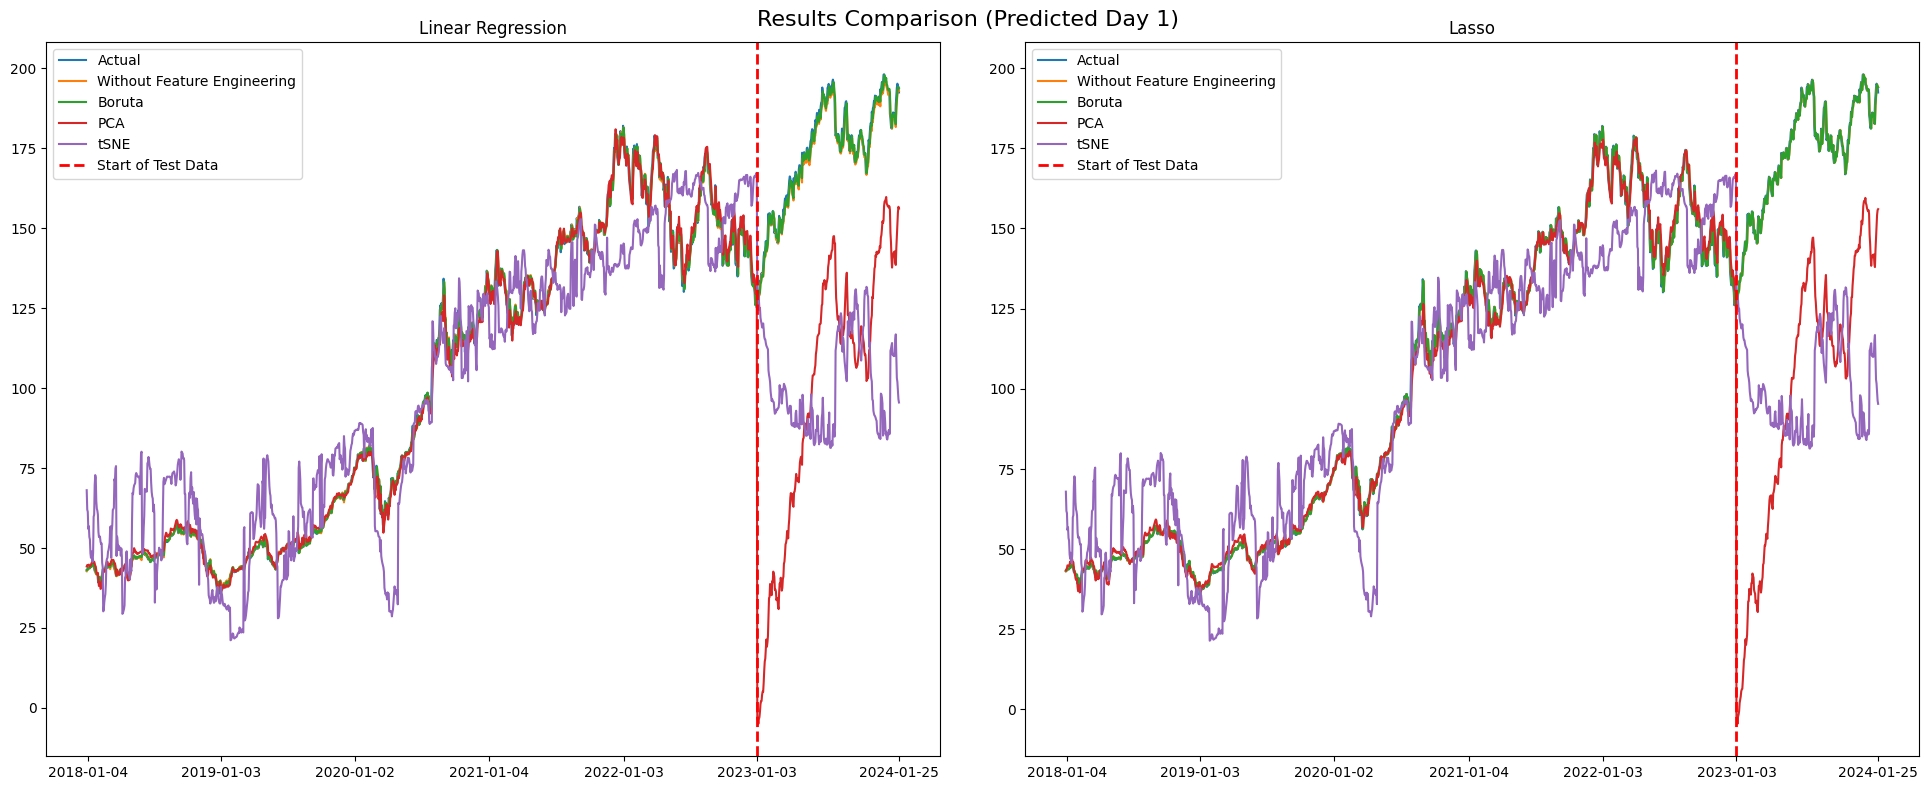

In [ ]:
plt.rcParams["figure.figsize"] = (20, 16) # Width, height in inches
date = np.concatenate((Train_date, Test_date), axis=0)
axis_x = np.array(['2018-01-04', '2019-01-03', '2020-01-02', '2021-01-04', '2022-01-03', '2023-01-03','2024-01-25'])
y_actual = np.concatenate((y_train, y_test), axis=0)
# For each subplot, you can now set individual titles and labels without them overlapping.
for key, value in model_name.items():
    ax = plt.subplot(2, 2, key + 1)
    model = key
    ax.set_title(value)
    plt.plot(y_actual, label='Actual')
    for key, value in pred_total.items():
        plt.plot(date, value[model], label=key)

    # Ensure the x parameter matches the format and actual point where the test data starts
    plt.axvline(x=np.where(date == '2023-01-03')[0][0], linewidth=2, color='r', linestyle='--', label='Start of Test Data')

    # Rotate xticks if they are overlapping

    # Set xticks to be more sparse to prevent overlap
    #plt.xticks(ticks=np.arange(0, len(date), step=int(len(date)/len(axis_x))), labels=axis_x)
    plt.xticks(axis_x)
    plt.legend()

# Adjust layout spacing to prevent labels and titles from overlapping
plt.tight_layout(pad=3.0)

# You can add a super title for the entire figure if you want
plt.suptitle('Results Comparison (Predicted Day 1)', fontsize=16)

# Show the plot
plt.show()